# Introduction
## Context
Today is 2012-12-10. You are a Senior Data Scientist at a large US publicly traded retailer. Before the end of the year the Chief Financial Officer (CFO) needs to put out a financial forecast for the coming calendar year (2013) to inform shareholders of expected business performance. You have been asked to provide these forecasts. 

You have been provided with 3 files; features.csv, sales.csv, stores.csv, which contain data about retail sales.

## Data Dictionary

**Features**:
| Field | Description |
|-------|-------------|
| Store | Store number |
| Date | Sales week date |
| Temperature | The average temperature in the region |
| Fuel_price | Cost of fuel in the region |
| Markdowns | Promotion discounts, only available after November 11 2010 and may not exist for every row |
| CPI | Consumer price index |
| Unemployment | Unemployment rate |
| isHoliday | Whether the week is considered a holiday or not |

**Sales**:
| Field | Description |
|-------|-------------|
| Store | Store number |
| Dept | Department number |
| Date | Sales week date |
| Weekly_sales | Sales for a given department in a store |
| isHoliday | Whether the week is considered a holiday or not |

**Stores**:
| Field | Description |
|-------|-------------|
| Store | Store number |
| Type | Store type |
| Size | The maximum number of items the store can hold |

## Objectives
* Predict next year's (2012-12-10 to 2013-12-10) weekly sales for each store.
* Provide your expectation of forecast performance during the period 2012-12-10 to 2013-12-10.
* Provide a visual plot to show actuals and forecasts across the time period 2010-01-10 to 2013-12-10.

## Datasets
* `features.csv`
* `sales.csv`
* `stores.csv`

# Summary
Created a `GradientBoosting` model that achieved the following results:
* MAPE: 1.47%
* RMSE: 878,438$

Forecasted Sales for the Period of 2012-12-10 to 2013-12-10: **$2635.28M**

Most stores are showing growth, at an average rate of **~7%**

There are a few stores that can be considered outliers due to the rate of growth/decline and very inconsistent sales. More accurate representation of their sales can be captured by getting more features and performing extended feature engineering.

# Data Preparation
## Modules, Functions Import & Configuration

In [1]:
# ==========================
# Standard Library Imports
# ==========================
import os
import warnings
import logging
import time
import joblib
from datetime import datetime

# ==========================
# Data Analysis & Visualization
# ==========================
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import HTML, Image

# ==========================
# Machine Learning Libraries
# ==========================
# Models & Classifiers
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
import optuna
from optuna.samplers import TPESampler
from sklearn.calibration import cross_val_predict

# Metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# ==========================
# Project-Specific Utilities
# ==========================
from utils import (
    get_screen_width,
    set_font_size,
    check_duplicates,
    boolean_analysis,
    datetime_analysis,
    missing_values,
    find_and_analyze_infinite_values,
    get_column_dtypes,
    plot_holiday_sales,
    plot_seasonal_sales,
    plot_feature_importances,
    calculate_ensemble_feature_importance,
    calculate_mi_feature_importance,
    phik_matrix,
    numerical_predictor_significance_test,
    categorical_predictor_significance_test,
    interpret_results_numerical,
    interpret_results_categorical,
    plot_continuous_relationships,
    plot_categorical_relationships,
    create_forecast_dataframe,
    forecast_store_sales,
    forecast_chain_sales,
    plot_store_forecast_performance,
    plot_chain_forecast_performance,
    plot_forecasted_sales,
    plot_store_metrics,
    train_and_plot_model_results,
    prepare_chain_data_for_tuning,
    plot_forecasted_sales_change,
)

# Constants
from utils import COLOR_PALETTE, RANDOM_STATE, EXPORT_FOLDER, DECAY_RATE
from utils import TRAIN_START, TRAIN_END, VALIDATION_START, VALIDATION_END
from utils import FORECAST_START, FORECAST_END

# Others
from utils import MeanEncoder

In [2]:
# Notebook Code Settings
TUNE_MODELS = False

In [3]:
# Suppress Warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.getLogger("lightgbm").setLevel(logging.CRITICAL)
os.environ["LIGHTGBM_VERBOSE"] = "-1"

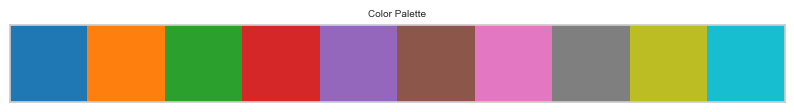

In [4]:
# Define random state, set visualization parameters
fig_width = get_screen_width() / 100
font_sizes = set_font_size()
plt.rcParams.update(font_sizes)
pd.set_option("display.max_colwidth", None)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option("display.max_rows", None)
HTML("<style>{}</style>".format(open("styles.css").read()))
display(
    HTML(
        """
    <style>
        .output_scroll {
            overflow: visible !important;
        }
    </style>
"""
    )
)

# Color style
color_palette = COLOR_PALETTE
sns.set_theme(font_scale=0.6)
sns.set_palette(color_palette)
sns.set_style("whitegrid", {"axes.grid": False})
sns.palplot(color_palette)
plt.title("Color Palette")
plt.show()

# Data Imports

In [5]:
df_features = pd.read_csv("data/features.csv")
df_sales = pd.read_csv("data/sales.csv")
df_stores = pd.read_csv("data/stores.csv")

## Features Dataset

In [6]:
pd.concat([df_features.head(), df_features.tail()])

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0         1  05/02/2010      42.3100      2.5720        NaN        NaN   
1         1  12/02/2010      38.5100      2.5480        NaN        NaN   
2         1  19/02/2010      39.9300      2.5140        NaN        NaN   
3         1  26/02/2010      46.6300      2.5610        NaN        NaN   
4         1  05/03/2010      46.5000      2.6250        NaN        NaN   
8185     45  28/06/2013      76.0500      3.6390  4842.2900   975.0300   
8186     45  05/07/2013      77.5000      3.6140  9090.4800  2268.5800   
8187     45  12/07/2013      79.3700      3.6140  3789.9400  1827.3100   
8188     45  19/07/2013      82.8400      3.7370  2961.4900  1047.0700   
8189     45  26/07/2013      76.0600      3.8040   212.0200   851.7300   

      MarkDown3  MarkDown4  MarkDown5      CPI  Unemployment  IsHoliday  
0           NaN        NaN        NaN 211.0964        8.1060      False  
1           NaN        NaN        NaN 211.2422        8.1060       True  
2           NaN        NaN        NaN 211.2891        8.1060      False  
3           NaN        NaN        NaN 211.3196        8.1060      False  
4           NaN        NaN        NaN 211.3501        8.1060      False  
8185     3.0000  2449.9700  3169.6900      NaN           NaN      False  
8186   582.7400  5797.4700  1514.9300      NaN           NaN      False  
8187    85.7200   744.8400  2150.3600      NaN           NaN      False  
8188   204.1900   363.0000  1059.4600      NaN           NaN      False  
8189     2.0600    10.8800  1864.5700      NaN           NaN      False

## Sales Dataset

In [7]:
pd.concat([df_sales.head(), df_sales.tail()])

Store  Dept        Date  Weekly_Sales  IsHoliday
0           1     1  05/02/2010    24924.5000      False
1           1     1  12/02/2010    46039.4900       True
2           1     1  19/02/2010    41595.5500      False
3           1     1  26/02/2010    19403.5400      False
4           1     1  05/03/2010    21827.9000      False
421565     45    98  28/09/2012      508.3700      False
421566     45    98  05/10/2012      628.1000      False
421567     45    98  12/10/2012     1061.0200      False
421568     45    98  19/10/2012      760.0100      False
421569     45    98  26/10/2012     1076.8000      False

## Stores Dataset

In [8]:
pd.concat([df_stores.head(), df_stores.tail()])

Store Type    Size
0       1    A  151315
1       2    A  202307
2       3    B   37392
3       4    A  205863
4       5    B   34875
40     41    A  196321
41     42    C   39690
42     43    C   41062
43     44    C   39910
44     45    B  118221

## Data Merging
Let's combine all three datasets into one DataFrame.

In [9]:
# Initial datatype conversions
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%d/%m/%Y')
df_features['Date'] = pd.to_datetime(df_features['Date'], format='%d/%m/%Y')

df = pd.merge(
    df_sales,
    df_features,
    on=['Store', 'Date', 'IsHoliday'],
    how='left'
)
    
df = pd.merge(
    df,
    df_stores,
    on='Store',
    how='left'
)

pd.concat([df.head(), df.tail()]).T

0                    1                    2       \
Store                           1                    1                    1   
Dept                            1                    1                    1   
Date          2010-02-05 00:00:00  2010-02-12 00:00:00  2010-02-19 00:00:00   
Weekly_Sales           24924.5000           46039.4900           41595.5500   
IsHoliday                   False                 True                False   
Temperature               42.3100              38.5100              39.9300   
Fuel_Price                 2.5720               2.5480               2.5140   
MarkDown1                     NaN                  NaN                  NaN   
MarkDown2                     NaN                  NaN                  NaN   
MarkDown3                     NaN                  NaN                  NaN   
MarkDown4                     NaN                  NaN                  NaN   
MarkDown5                     NaN                  NaN                  NaN   
CPI                      211.0964             211.2422             211.2891   
Unemployment               8.1060               8.1060               8.1060   
Type                            A                    A                    A   
Size                       151315               151315               151315   

                           3                    4                    421565  \
Store                           1                    1                   45   
Dept                            1                    1                   98   
Date          2010-02-26 00:00:00  2010-03-05 00:00:00  2012-09-28 00:00:00   
Weekly_Sales           19403.5400           21827.9000             508.3700   
IsHoliday                   False                False                False   
Temperature               46.6300              46.5000              64.8800   
Fuel_Price                 2.5610               2.6250               3.9970   
MarkDown1                     NaN                  NaN            4556.6100   
MarkDown2                     NaN                  NaN              20.6400   
MarkDown3                     NaN                  NaN               1.5000   
MarkDown4                     NaN                  NaN            1601.0100   
MarkDown5                     NaN                  NaN            3288.2500   
CPI                      211.3196             211.3501             192.0136   
Unemployment               8.1060               8.1060               8.6840   
Type                            A                    A                    B   
Size                       151315               151315               118221   

                           421566               421567               421568  \
Store                          45                   45                   45   
Dept                           98                   98                   98   
Date          2012-10-05 00:00:00  2012-10-12 00:00:00  2012-10-19 00:00:00   
Weekly_Sales             628.1000            1061.0200             760.0100   
IsHoliday                   False                False                False   
Temperature               64.8900              54.4700              56.4700   
Fuel_Price                 3.9850               4.0000               3.9690   
MarkDown1               5046.7400            1956.2800            2004.0200   
MarkDown2                     NaN                  NaN                  NaN   
MarkDown3                 18.8200               7.8900               3.1800   
MarkDown4               2253.4300             599.3200             437.7300   
MarkDown5               2340.0100            3990.5400            1537.4900   
CPI                      192.1704             192.3273             192.3309   
Unemployment               8.6670               8.6670               8.6670   
Type                            B                    B                    B   
Size                       118221               118221               118221

In [10]:
print(f"Dataset size: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset size: 421570 rows, 16 columns


<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <ul>Dataset contais 421,570 rows</ul>
        <ul>15 features, regression task</ul>
        <ul>Some features contain missing values</ul>
    </ol>
</div>

# Data Formatting & Cleaning

## Correct
* Check for duplicates, remove if necessary.
* Check statistical summaries, remove errors.

In [11]:
check_duplicates(df, "Sales by Week")

DataFrame: Sales by Week
Total rows: 421570
Duplicate rows: 0



In [12]:
df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
dtype: object

### Statistical Summary - Numerical Columns

In [13]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
round(df[numerical_columns].describe(), 2).T

count        mean        std        min        25%  \
Store        421570.0000     22.2000    12.7900     1.0000    11.0000   
Dept         421570.0000     44.2600    30.4900     1.0000    18.0000   
Weekly_Sales 421570.0000  15981.2600 22711.1800 -4988.9400  2079.6500   
Temperature  421570.0000     60.0900    18.4500    -2.0600    46.6800   
Fuel_Price   421570.0000      3.3600     0.4600     2.4700     2.9300   
MarkDown1    150681.0000   7246.4200  8291.2200     0.2700  2240.2700   
MarkDown2    111248.0000   3334.6300  9475.3600  -265.7600    41.6000   
MarkDown3    137091.0000   1439.4200  9623.0800   -29.1000     5.0800   
MarkDown4    134967.0000   3383.1700  6292.3800     0.2200   504.2200   
MarkDown5    151432.0000   4628.9800  5962.8900   135.1600  1878.4400   
CPI          421570.0000    171.2000    39.1600   126.0600   132.0200   
Unemployment 421570.0000      7.9600     1.8600     3.8800     6.8900   
Size         421570.0000 136727.9200 60980.5800 34875.0000 93638.0000   

                     50%         75%         max  
Store            22.0000     33.0000     45.0000  
Dept             37.0000     74.0000     99.0000  
Weekly_Sales   7612.0300  20205.8500 693099.3600  
Temperature      62.0900     74.2800    100.1400  
Fuel_Price        3.4500      3.7400      4.4700  
MarkDown1      5347.4500   9210.9000  88646.7600  
MarkDown2       192.0000   1926.9400 104519.5400  
MarkDown3        24.6000    103.9900 141630.6100  
MarkDown4      1481.3100   3595.0400  67474.8500  
MarkDown5      3359.4500   5563.8000 108519.2800  
CPI             182.3200    212.4200    227.2300  
Unemployment      7.8700      8.5700     14.3100  
Size         140167.0000 202505.0000 219622.0000

<div class="next-steps">
    <h3>Observations</h3>
    <p>Numerical Columns</p>
    <ol>
        <ul>13 numeric features, markdown-related features are missing values</ul>
        <ul>The negative <code>min</code> value for <code>Weekly_Sales</code> and <code>MarkDown</code> features could have many reasons (refunds, errors in accounting)</ul>
        <ul>The <code>max</code> value for <code>Weekly_Sales</code> and <code>MarkDown</code> features is much larger than the average. This could be an accounting error or the retail chain has some very large stores with large discounts</ul>
    </ol>
</div>

### Numerical Features - Negative Values
We observed that `Weekly_Sales`, `MarkDown2` and `MarkDown3` have negative values. Let's explore whether these values are intentional or potential errors.

In [14]:
df_neg_sales = df[df['Weekly_Sales'] < 0]
print(f"Instances with negative weekly sales: {df_neg_sales.shape[0]}")

Instances with negative weekly sales: 1285


In [15]:
print(f"Total unique weeks: {df.groupby('Date')['Weekly_Sales'].count().shape[0]}")
df_neg_sales_date = df_neg_sales.groupby('Date')['Weekly_Sales'].count()

print(f"Weeks with negative sales: {df_neg_sales_date.shape[0]}")
print(f"Minimum date: {df_neg_sales['Date'].min()}")
print(f"Maximum date: {df_neg_sales['Date'].max()}")
df_neg_sales_date.sort_values(ascending=False).head(10)

Total unique weeks: 143
Weeks with negative sales: 143
Minimum date: 2010-02-05 00:00:00
Maximum date: 2012-10-26 00:00:00


Date
2012-05-11    19
2011-12-30    18
2010-12-31    18
2011-06-10    18
2010-05-07    17
2011-01-07    16
2012-01-13    14
2010-12-03    14
2012-04-27    14
2011-07-01    14
Name: Weekly_Sales, dtype: int64

Each week of the dataset had negative values. Additionally, we don't see any extreme outliers in top 10 weeks by negative sales.

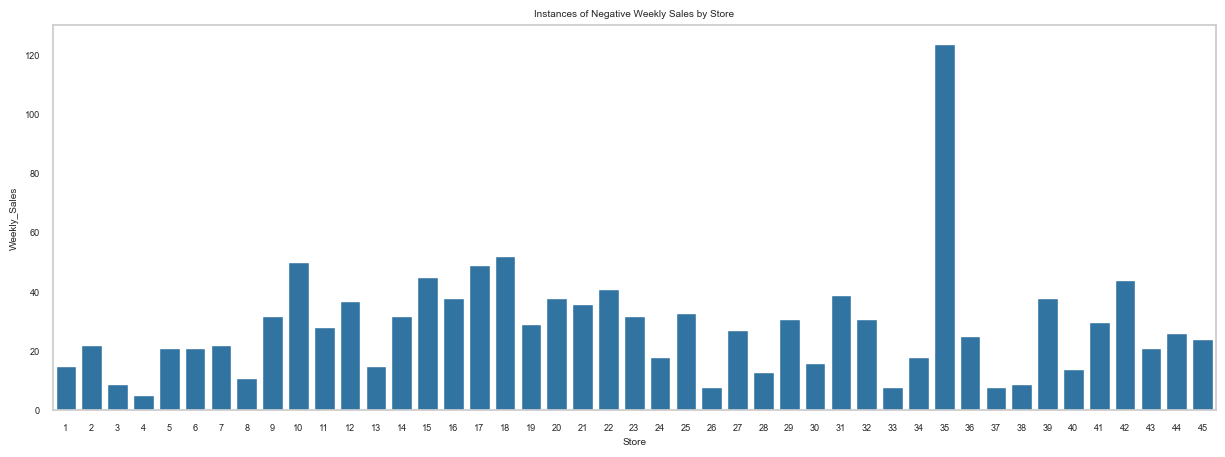

In [16]:
df_neg_sales_store = df_neg_sales.groupby('Store')['Weekly_Sales'].count()
plt.figure(figsize=(15, 5))
sns.barplot(x = df_neg_sales_store.sort_values(ascending=False).index,
            y = df_neg_sales_store.sort_values(ascending=False))
plt.title("Instances of Negative Weekly Sales by Store")
plt.show()

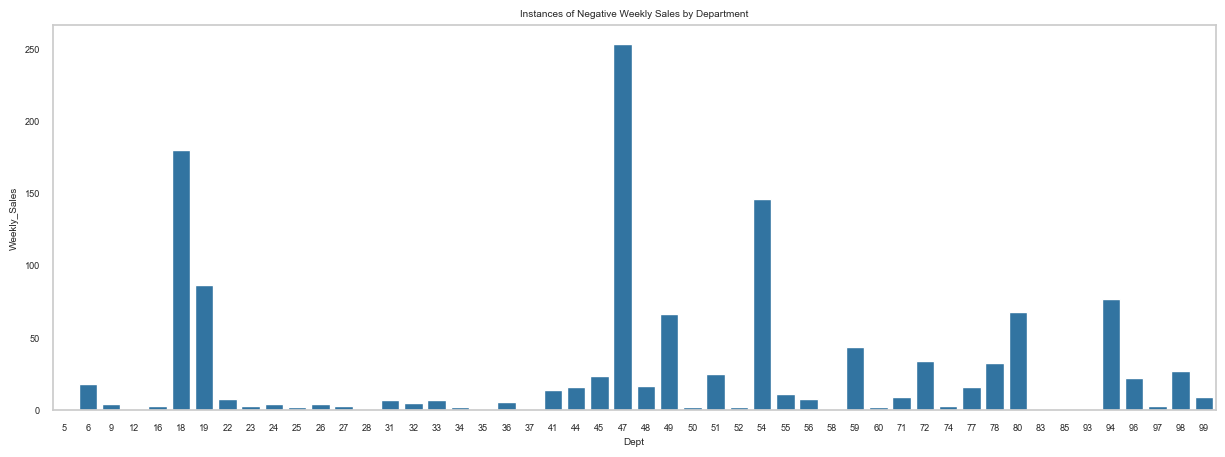

In [17]:
df_neg_sales_dept = df_neg_sales.groupby('Dept')['Weekly_Sales'].count()
plt.figure(figsize=(15, 5))
sns.barplot(x = df_neg_sales_dept.sort_values(ascending=False).index,
            y = df_neg_sales_dept.sort_values(ascending=False))
plt.title("Instances of Negative Weekly Sales by Department")
plt.show()

In [18]:
del df_neg_sales, df_neg_sales_store, df_neg_sales_dept

It seems that negative weekly sales are not a one-time occurrence.
* Occurred in 143 weeks - throughout the entirety of the dataset.
* No particular outliers for occurrence.
* All stores have such cases.
* Most departments have such cases, although not all of them. Some departments have relatively higher frequencies than others.

In essence, it seems that this is not an error, and could be a case of refunds. Accounting adjustments might not be applicable here as well, since negative sales occurred in all weeks, and you would expect these adjustments to occur during month start.

Let's explore the negative values of MarkDown features. As we observed in the statistical summary, only `MarkDown2` and `Markdown3` had negative values.

In [19]:
df_neg_markdown = df[(df['MarkDown2'] < 0) | (df['MarkDown3'] < 0)]
print(f"Instances with negative MarkDown2: {df[df['MarkDown2'] < 0].shape[0]}")
print(f"Instances with negative MarkDown3: {df[df['MarkDown3'] < 0].shape[0]}")

Instances with negative MarkDown2: 1311
Instances with negative MarkDown3: 257


In [20]:
df_neg_markdown_date = df_neg_markdown.groupby('Date').agg(
    IsHoliday=('IsHoliday', 'min'),
    MarkDown2_neg_count=('MarkDown2', lambda x: (x < 0).sum()),
    MarkDown3_neg_count=('MarkDown3', lambda x: (x < 0).sum())
).reset_index()
df_neg_markdown_date.sort_values(by='Date', ascending=True)

Date  IsHoliday  MarkDown2_neg_count  MarkDown3_neg_count
0  2011-12-09      False                    0                   46
1  2012-03-16      False                   72                    0
2  2012-03-23      False                   71                    0
3  2012-03-30      False                    0                   70
4  2012-04-27      False                  141                   69
5  2012-05-11      False                   72                    0
6  2012-06-01      False                   73                    0
7  2012-06-08      False                    0                   72
8  2012-06-29      False                   69                    0
9  2012-07-06      False                   68                    0
10 2012-07-13      False                   70                    0
11 2012-07-20      False                   70                    0
12 2012-08-10      False                   62                    0
13 2012-08-17      False                   60                    0
14 2012-08-24      False                  141                    0
15 2012-09-07       True                  273                    0
16 2012-10-26      False                   69                    0

`MarkDown2` had 14 weeks with negative values, while `MarkDown3` had 4 weeks. Most occurrences with negative `MarkDown2` occurred during a holiday week, and it is the only holiday week during all occurrences of negative `MarkDown2` or `MarkDown3`. Let's investigate whether this negative `MarkDown` occurrence is exclusive to a specific store or department.

In [21]:
df_neg_markdown_store = df_neg_markdown.groupby('Store').agg(
    MarkDown2_neg_count=('MarkDown2', lambda x: (x < 0).sum()),
    MarkDown3_neg_count=('MarkDown3', lambda x: (x < 0).sum())
).reset_index()
df_neg_markdown_store

Store  MarkDown2_neg_count  MarkDown3_neg_count
0       4                   71                    0
1       5                   60                    0
2       9                  124                    0
3      10                  142                    0
4      12                   68                    0
5      14                   70                    0
6      15                  138                    0
7      16                   68                    0
8      19                   71                    0
9      20                   72                    0
10     24                   72                    0
11     28                    0                   72
12     31                   70                   70
13     34                   71                    0
14     35                   69                    0
15     36                    0                   46
16     39                    0                   69
17     41                  145                    0

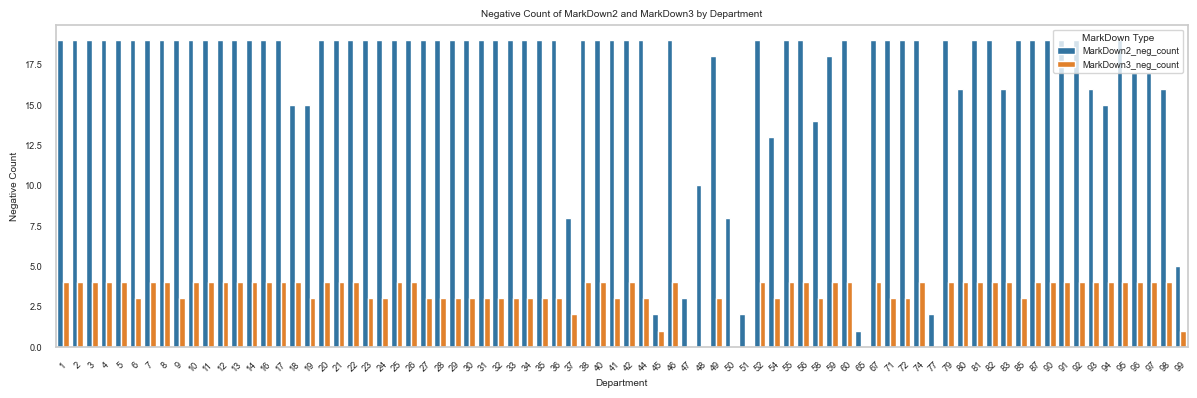

In [22]:
df_neg_markdown_dept = df_neg_markdown.groupby('Dept').agg(
    MarkDown2_neg_count=('MarkDown2', lambda x: (x < 0).sum()),
    MarkDown3_neg_count=('MarkDown3', lambda x: (x < 0).sum())
).reset_index()

df_melted = df_neg_markdown_dept.melt(
    id_vars='Dept',
    value_vars=['MarkDown2_neg_count', 'MarkDown3_neg_count'],
    var_name='MarkDown_Type',
    value_name='Negative_Count'
)
plt.figure(figsize=(12, 4))
sns.barplot(
    data=df_melted,
    x='Dept',
    y='Negative_Count',
    hue='MarkDown_Type',
    palette=COLOR_PALETTE
)
plt.title('Negative Count of MarkDown2 and MarkDown3 by Department')
plt.xlabel('Department')
plt.ylabel('Negative Count')
plt.xticks(rotation=45)
plt.legend(title='MarkDown Type')
plt.tight_layout()
plt.show()

The patterns suggest these negative markdowns are intentional rather than errors:
* Consistent frequencies across departments
* Regular temporal patterns
* Store-level variation but department-level consistency

`MarkDown2` and `MarkDown3` appear to be managed independently:
* Rarely overlap in timing
* Generally mutually exclusive at store level (except Store 31)
* Different patterns of department coverage

The Labor Day spike in `MarkDown2` suggests possible relationship with holiday/seasonal pricing strategies, though this is the only holiday occurrence in the dataset. In essence, it appears that it is a price hiking strategy that is based on seasonality, holidays or external circumstances (competitors, inflation, etc.)

### Statistical Summary - Categorical Columns

In [23]:
categorical_columns = (
    df.select_dtypes(exclude=[np.number, 'datetime64[ns]', 'bool']).columns
)
round(df[categorical_columns].describe(), 2)

Type
count   421570
unique       3
top          A
freq    215478

<div class="next-steps">
    <h3>Observations</h3>
    <p>Categorical Columns</p>
    <ol>
        <ul>1 categorical feature, no missing values</ul>
        <ul>Three store types in total. Store type 'A' is most frequent.</ul>
    </ol>
</div>

In [24]:
categorical_columns

Index(['Type'], dtype='object')

### Statistical Summary - Other Columns

In [25]:
bool_stats = boolean_analysis(df, ["IsHoliday"])
bool_stats.T

column             IsHoliday
count            421570.0000
null_count            0.0000
true_count        29661.0000
false_count      391909.0000
true_percentage       7.0358
false_percentage     92.9642

In [26]:
datetime_stats = datetime_analysis(df, ["Date"])
datetime_stats.T

column                       Date
count                      421570
min           2010-02-05 00:00:00
max           2012-10-26 00:00:00
range           994 days 00:00:00
mode          2011-12-23 00:00:00
null_count                      0
unique_count                  143

<div class="next-steps">
    <h3>Observations</h3>
    <p>Other Columns</p>
    <ol>
        <ul>7% of instances will be during a holiday</ul>
        <ul>The dataset spans 2.7 years</ul>
        <ul>No missing values in both features</ul>
    </ol>
</div>

## Complete
Deal with missing values in the dataset.

In [27]:
missing_values(df)

Data Type  Count #  Perc %
MarkDown2            float64   310322 73.6000
MarkDown4            float64   286603 68.0000
MarkDown3            float64   284479 67.5000
MarkDown1            float64   270889 64.3000
MarkDown5            float64   270138 64.1000
Store                  int64        0  0.0000
Dept                   int64        0  0.0000
Date          datetime64[ns]        0  0.0000
Weekly_Sales         float64        0  0.0000
IsHoliday               bool        0  0.0000
Temperature          float64        0  0.0000
Fuel_Price           float64        0  0.0000
CPI                  float64        0  0.0000
Unemployment         float64        0  0.0000
Type                  object        0  0.0000
Size                   int64        0  0.0000

In the data dictionary, we get the following information for `MarkDown` columns:

Promotion discounts, only available after November 11 2010 and may not exist for every row. This means the following:
* Missing values before 2010-11-11 can be regarded as "structural missing values"
* Missing values after this period mean that no markdown was applied.

To handle this case effectively, we will do the following:
* Create a new feature `markdown_available`, which is `True` for all instances in and after 2010-11-11. For earlier instances it is `False`
* Impute all NaN values with 0

In [28]:
from datetime import datetime

cutoff_date = datetime(2011, 11, 11)
df['markdown_available'] = (df['Date'] >= cutoff_date).astype(bool)

markdown_cols = [col for col in df.columns if 'MarkDown' in col]
df[markdown_cols] = df[markdown_cols].fillna(0)

print("\nValidation Summary:")
print(f"Records before cutoff: {(df['Date'] <= cutoff_date).sum()}")
print(f"Records after cutoff: {(df['Date'] > cutoff_date).sum()}")
print(df['markdown_available'].value_counts(normalize=True).round(2))


Validation Summary:
Records before cutoff: 273103
Records after cutoff: 148467
markdown_available
False   0.6400
True    0.3600
Name: proportion, dtype: float64


In [29]:
missing_values(df)

Data Type  Count #  Perc %
Store                        int64        0  0.0000
MarkDown3                  float64        0  0.0000
Size                         int64        0  0.0000
Type                        object        0  0.0000
Unemployment               float64        0  0.0000
CPI                        float64        0  0.0000
MarkDown5                  float64        0  0.0000
MarkDown4                  float64        0  0.0000
MarkDown2                  float64        0  0.0000
Dept                         int64        0  0.0000
MarkDown1                  float64        0  0.0000
Fuel_Price                 float64        0  0.0000
Temperature                float64        0  0.0000
IsHoliday                     bool        0  0.0000
Weekly_Sales               float64        0  0.0000
Date                datetime64[ns]        0  0.0000
markdown_available            bool        0  0.0000

<div class="next-steps">
    <h3>Observations</h3>
    <p>Missing values</p>
    <ol>
        <ul><code>MarkDown</code> features had missing values. Part of it is due to the data being unavailable during the dataset collection, in other cases it was due to no markdowns being applied</ul>
        <ul>All missing values were imputed with 0. The instances before and after the feature was started to track were defined by the <code>markdown_available</code> flag</ul>
    </ol>
</div>

For statistical modeling baseline, let's export the current state of the dataset.

In [30]:
df.to_csv(EXPORT_FOLDER + '\\df_raw.csv', index=False)

## Create
Create additional features based on provided dataset context to improve EDA.

Time-based features to capture cyclical trends:
* `Month_sin`
* `Month_cos`
* `Week_sin`
* `Week_cos`

Seasonality patterns, how much sales differ from the mean each month:
* `month_multiplier`
* `store_month_multiplier`
* `dept_month_multiplier`

Holiday patterns, how much sales differ from the mean during holidays:
* `holiday_multiplier`
* `holiday_store_multiplier`
* `holiday_dept_multiplier`

Encoding of the `Type` column.

Feature creation is not very extensive, as we will perform forecasting, and the majority of the data we currently have will be unknown. The seasonality and holiday patterns can be applied on forecasts as constants, and the time-based features can be calculated for the forecast period, independent of other variables.

In [31]:
def create_forecast_features(df):
    data = df.copy()
    data['Date'] = pd.to_datetime(data['Date'])

    # Time Features
    data['Month'] = data['Date'].dt.month
    data['Week'] = data['Date'].dt.isocalendar().week
    data['Month_sin'] = np.sin(2 * np.pi * data['Month']/12).astype(float)
    data['Month_cos'] = np.cos(2 * np.pi * data['Month']/12).astype(float)
    data['Week_sin'] = np.sin(2 * np.pi * data['Week']/52).astype(float)
    data['Week_cos'] = np.cos(2 * np.pi * data['Week']/52).astype(float)

    # Monthly seasonality
    monthly_pattern = data.groupby('Month')['Weekly_Sales'].mean() / data['Weekly_Sales'].mean()
    data['month_multiplier'] = data['Month'].map(monthly_pattern)

    # Store-Month seasonality
    store_month_means = data.groupby(['Store', 'Month'])['Weekly_Sales'].mean()
    store_means = data.groupby('Store')['Weekly_Sales'].mean()
    store_month_pattern = pd.DataFrame(
        store_month_means.values / store_means[store_month_means.index.get_level_values('Store')].values,
        index=store_month_means.index
    )
    data['store_month_multiplier'] = data.set_index(['Store', 'Month']).index.map(store_month_pattern[0]).values

    # Department-Month seasonality
    dept_month_means = data.groupby(['Dept', 'Month'])['Weekly_Sales'].mean()
    dept_means = data.groupby('Dept')['Weekly_Sales'].mean()
    dept_month_pattern = pd.DataFrame(
        dept_month_means.values / dept_means[dept_month_means.index.get_level_values('Dept')].values,
        index=dept_month_means.index
    )
    data['dept_month_multiplier'] = data.set_index(['Dept', 'Month']).index.map(dept_month_pattern[0]).values
    
    # Holiday multipliers
    holiday_dates = data[data['IsHoliday']]['Date'].unique()
    holiday_multipliers = {}
    
    for holiday_date in holiday_dates:
        holiday_sales = data[data['Date'] == holiday_date]['Weekly_Sales'].mean()
        non_holiday_sales = data[~data['IsHoliday']]['Weekly_Sales'].mean()
        holiday_multipliers[holiday_date] = holiday_sales / non_holiday_sales
    
    data['holiday_multiplier'] = 1.0
    for holiday_date, multiplier in holiday_multipliers.items():
        mask = data['Date'] == holiday_date
        data.loc[mask, 'holiday_multiplier'] = multiplier
    
    # Store-specific holiday multipliers
    store_holiday_multipliers = {}
    for store in data['Store'].unique():
        store_data = data[data['Store'] == store]
        store_holiday_dates = store_data[store_data['IsHoliday']]['Date'].unique()
        
        for holiday_date in store_holiday_dates:
            holiday_sales = store_data[store_data['Date'] == holiday_date]['Weekly_Sales'].mean()
            non_holiday_sales = store_data[~store_data['IsHoliday']]['Weekly_Sales'].mean()
            store_holiday_multipliers[(store, holiday_date)] = holiday_sales / non_holiday_sales
    
    data['holiday_store_multiplier'] = 1.0
    for (store, holiday_date), multiplier in store_holiday_multipliers.items():
        mask = (data['Store'] == store) & (data['Date'] == holiday_date)
        data.loc[mask, 'holiday_store_multiplier'] = multiplier
    
    # Department-specific holiday multipliers
    dept_holiday_multipliers = {}
    for dept in data['Dept'].unique():
        dept_data = data[data['Dept'] == dept]
        dept_holiday_dates = dept_data[dept_data['IsHoliday']]['Date'].unique()
        
        for holiday_date in dept_holiday_dates:
            holiday_sales = dept_data[dept_data['Date'] == holiday_date]['Weekly_Sales'].mean()
            non_holiday_sales = dept_data[~dept_data['IsHoliday']]['Weekly_Sales'].mean()
            dept_holiday_multipliers[(dept, holiday_date)] = holiday_sales / non_holiday_sales
    
    data['holiday_dept_multiplier'] = 1.0
    for (dept, holiday_date), multiplier in dept_holiday_multipliers.items():
        mask = (data['Dept'] == dept) & (data['Date'] == holiday_date)
        data.loc[mask, 'holiday_dept_multiplier'] = multiplier

    # Drop intermediate columns
    data = data.drop(columns=['Month', 'Week'])

    return data.fillna(0)

In [32]:
print(f"Initial Dataset size: {df.shape[0]} rows, {df.shape[1]} columns")
df = create_forecast_features(df)
print(f"Dataset size (post-FE): {df.shape[0]} rows, {df.shape[1]} columns")

Initial Dataset size: 421570 rows, 17 columns
Dataset size (post-FE): 421570 rows, 27 columns


We created 9 new features. Let's check for missing features & infinite values.

In [33]:
missing_values(df, missing_only=True)

Empty DataFrame
Columns: [Data Type, Count #, Perc %]
Index: []

In [34]:
find_and_analyze_infinite_values(df)

No rows with infinite values found.


Let's remove features that will not be necessary:
* `Markdown` columns: difficult to anticipate discount practices & refunds
* `Date` - we have already extracted meaningful information

In [35]:
df = df.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3',
                        'MarkDown4', 'MarkDown5', 'markdown_available'], axis=1)

## Convert
Review and change columns` datatypes, if necessary.

In [36]:
get_column_dtypes(df)

dtype
IsHoliday                           bool
Date                      datetime64[ns]
Weekly_Sales                     float64
Temperature                      float64
Fuel_Price                       float64
CPI                              float64
Unemployment                     float64
Month_sin                        float64
Month_cos                        float64
Week_sin                         float64
Week_cos                         float64
month_multiplier                 float64
store_month_multiplier           float64
dept_month_multiplier            float64
holiday_multiplier               float64
holiday_store_multiplier         float64
holiday_dept_multiplier          float64
Store                              int64
Dept                               int64
Size                               int64
Type                              object

Features` datatypes are correct, let's proceed to EDA.

# Exploratory Data Analysis
Let's explore the target variable and it's relationship to predictor variables.

## Target Variable
### Value Trends

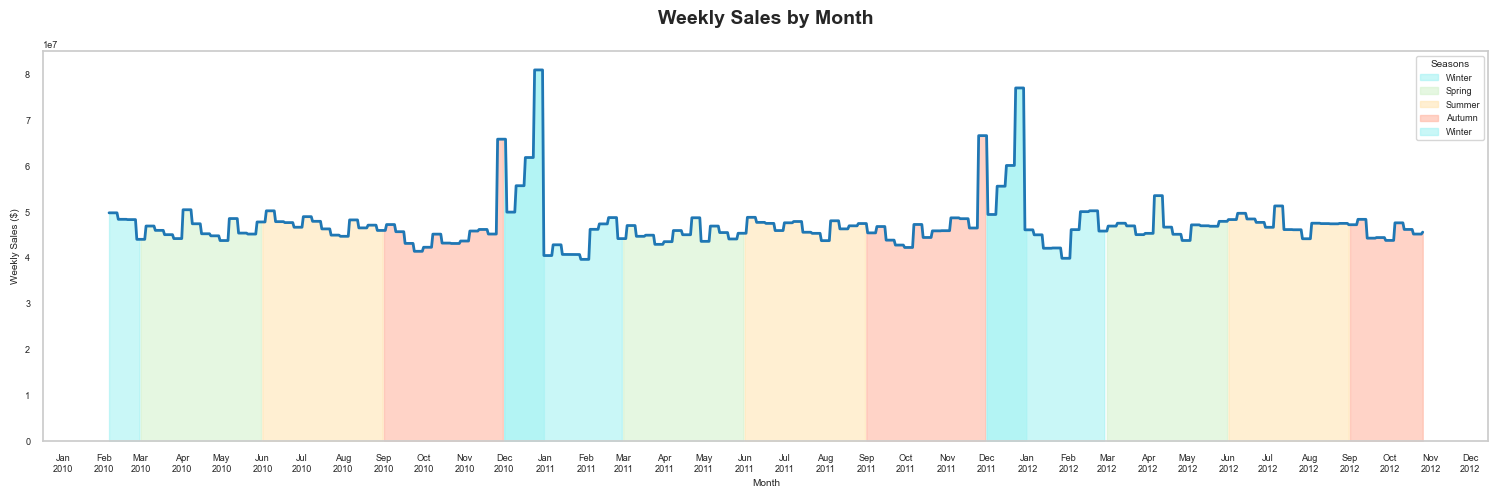

In [37]:
plot_seasonal_sales(df)

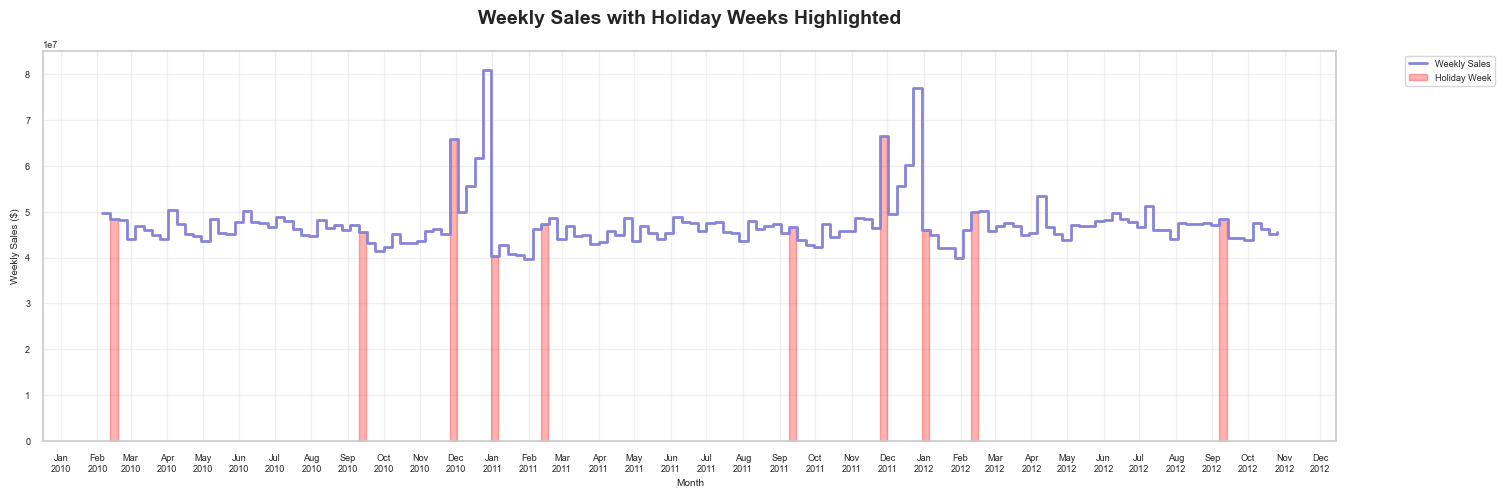

In [38]:
plot_holiday_sales(df)

We have the following Holiday Weeks:
* Valentine's Day - middle of February
* Labor Day - middle of September
* Thanksgiving & Black Friday - end of November
* New Year's Eve - end of December/start of January

Thanksgiving & Black Friday have a surge in sales, followed by a surge at the end of December for Christmas & New Year's Eve. Other holiday weeks don't seem to have as big of an impact.

<div class="next-steps">
    <h3>Observations</h3>
    <p>Weekly Sales</p>
    <ol>
        <ul>Weekly Sales seem to follow a stable trend YoY</ul>
        <ul>Sales ramp-up at the end of November and are highest in December</ul>
        <ul>There is a slight drop in sales at the start of the year in January</ul>
        <ul>Thanksgiving & Black Friday, paired with Christmas and New Year's Eve explain the surge in weekly sales</ul>
    </ol>
</div>

## Feature Importance
Let's see how each feature is deterministic with regards to the target variable. First, let's prepare the data.
* Remove `Data` as we have already derived meaningful information from this feature
* Encode the `Type` feature

In [39]:
df = df.drop(columns=['Date'], axis=1)
target_column = 'Weekly_Sales'
mean_encoding_cols = ['Dept', 'Store', 'Type']
X = df.drop(columns=[target_column], axis=1)
y = df[target_column]
mean_encoder = MeanEncoder(columns=mean_encoding_cols)
mean_encoded = mean_encoder.fit_transform(X, y)
X_encoded = pd.concat(
                [X.drop(columns=mean_encoding_cols, axis=1),
                mean_encoded[mean_encoding_cols]], axis=1
            )

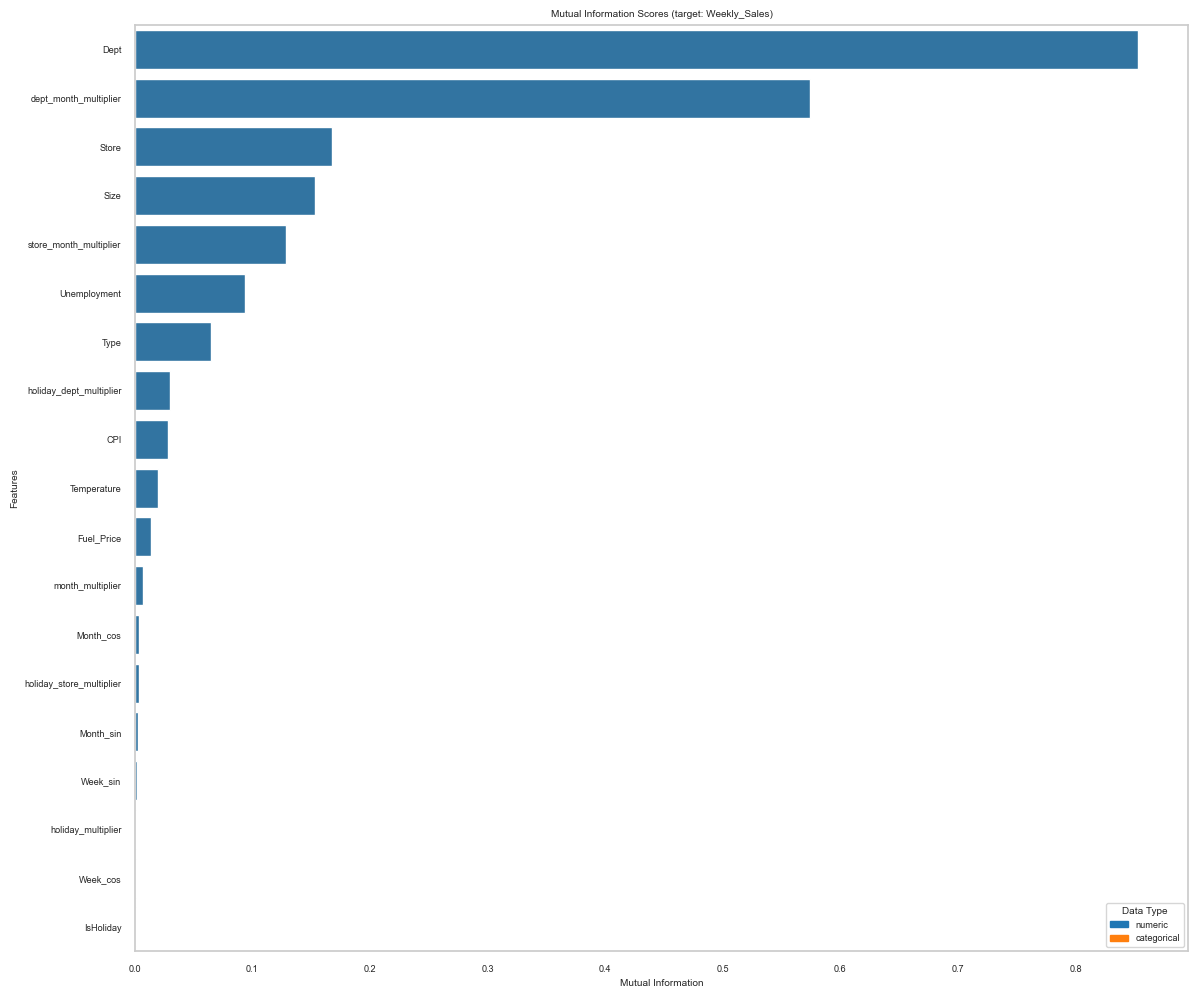

In [40]:
mi_importance = calculate_mi_feature_importance(X_encoded, y)
plot_feature_importances(mi_importance, 'Weekly_Sales', 'Mutual Information')

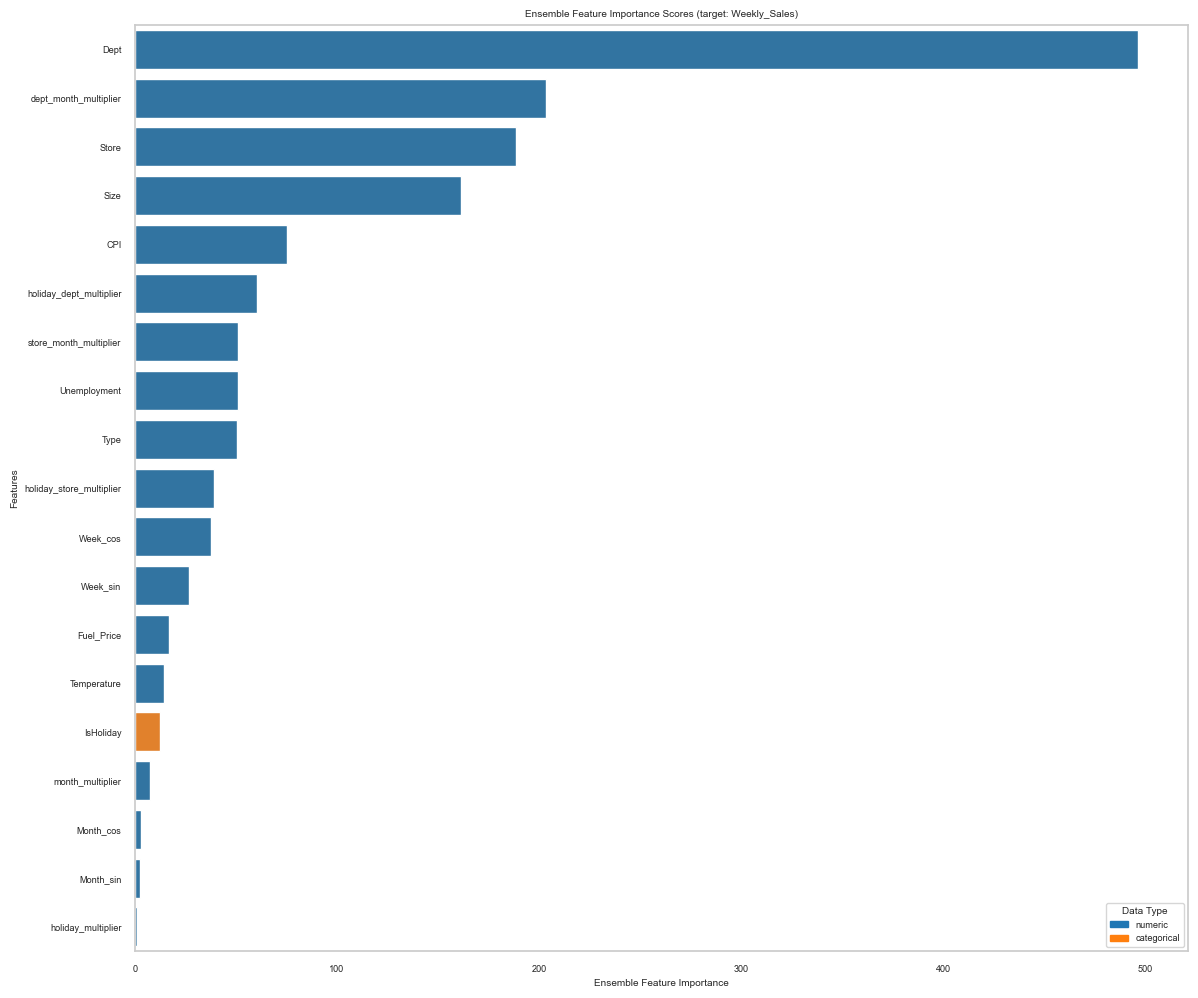

In [41]:
ensemble_importance = calculate_ensemble_feature_importance(X_encoded, y)
plot_feature_importances(ensemble_importance, 'Weekly_Sales', 'Ensemble Feature Importance')

<div class="next-steps">
    <h3>Observations</h3>
    <p>Feature Importance</p>
    <ol>
        <ul>Both approaches show <code>Dept</code> to be the most important feature in determining weekly sales, followed by <code>Store</code> and <code>Size</code></ul>
        <ul>Custom-made seasonality features within the context of a store or department seem to have high importance</ul>
        <ul>Week and Month-based cyclical features do not show much importance to both approaches</ul>
    </ol>
</div>

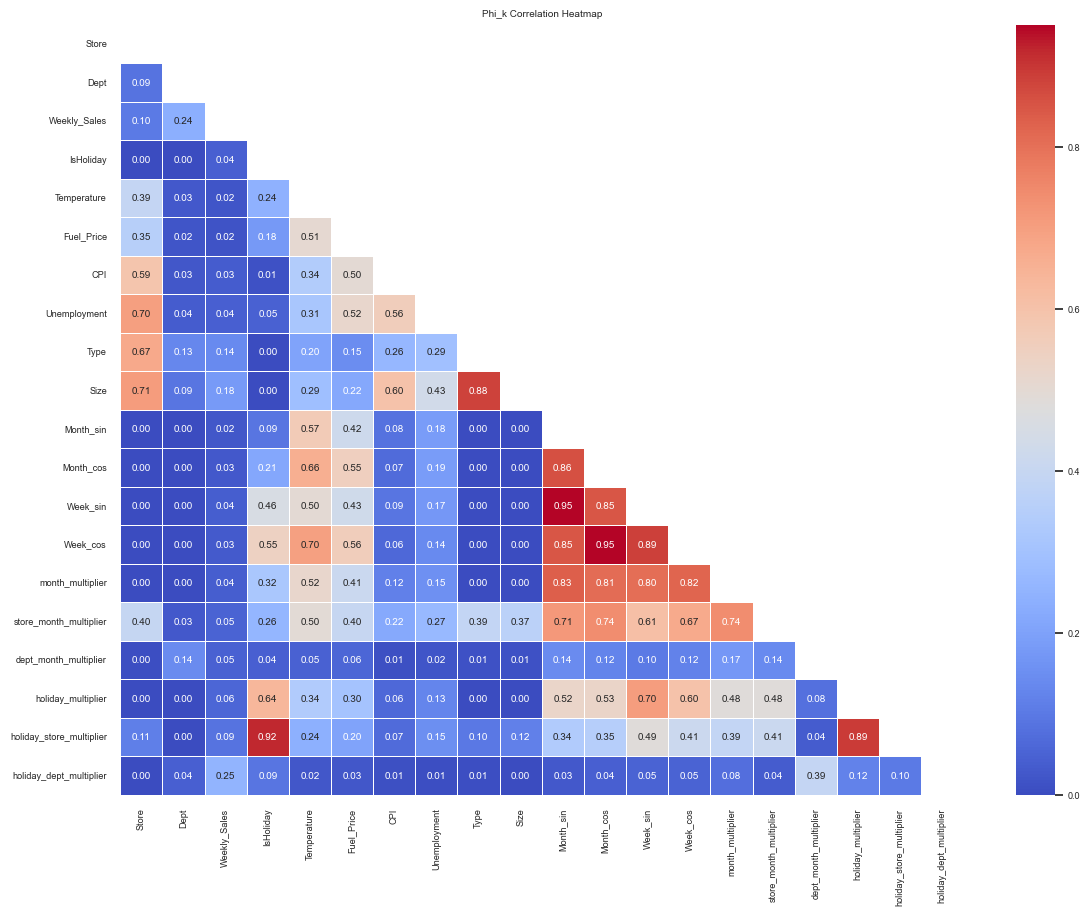

In [42]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
corr_target, top_interactions = phik_matrix(
    df, numerical_columns, 'Weekly_Sales', mi_importance
)

In [43]:
corr_target

Feature  Phik Coefficient
0   holiday_dept_multiplier            0.2507
1                      Dept            0.2366
2                      Size            0.1804
3                      Type            0.1401
4                     Store            0.1036
5  holiday_store_multiplier            0.0887
6        holiday_multiplier            0.0593
7    store_month_multiplier            0.0507
8     dept_month_multiplier            0.0462
9              Unemployment            0.0444

In [44]:
top_interactions

Feature1                  Feature2  Phik Coefficient  \
212           Month_sin                  Week_sin            0.9504   
233           Month_cos                  Week_cos            0.9483   
78            IsHoliday  holiday_store_multiplier            0.9181   
358  holiday_multiplier  holiday_store_multiplier            0.8919   
272            Week_cos                  Week_sin            0.8852   
188                Size                      Type            0.8805   
230           Month_cos                 Month_sin            0.8602   
232           Month_cos                  Week_sin            0.8482   
213           Month_sin                  Week_cos            0.8468   
214           Month_sin          month_multiplier            0.8337   

     Feature1 Score  Feature2 Score  
212          0.0030          0.0019  
233          0.0038          0.0011  
78           0.0008          0.0037  
358          0.0012          0.0037  
272          0.0011          0.0019  
188          0.1534          0.0651  
230          0.0038          0.0030  
232          0.0038          0.0019  
213          0.0030          0.0011  
214          0.0030          0.0071

<div class="next-steps">
    <h3>Observations</h3>
    <p>PhiK Matrix</p>
    <ol>
        <ul>Similarly to the feature importances, <code>Dept</code> and <code>holiday_dept_multiplier</code> seem to be important features in predicting weekly sales</ul>
        <ul>Store <code>Type</code> is highly correlated to the Store <code>Size</code></ul>
        <ul>Time-based features don't seem to have much importance in the matrix as well, and will be removed once other features are assigned to the forecast period</ul>
    </ol>
</div>

## Numerical predictors
Let's explore the feature-target interactions through distributions. Statistical significance is expressed through two metrics:
* **p-value** - likelihood of null hypothesis (the feature makes two classes of clients different)
* **Effect Magnitude** - the practical significance of the difference

Since we have a lot of numerical features, let's analyze the first 20 features by feature importance

In [45]:
df['Dept'] = df['Dept'].astype(str)
df['Store'] = df['Store'].astype(str)

In [46]:
df_significance_num = pd.DataFrame()
numerical_columns = df.select_dtypes(include=[np.number]).columns
numerical_columns = [col for col in numerical_columns if col != target_column]

Sampled DataFrame size: (10000, 20)


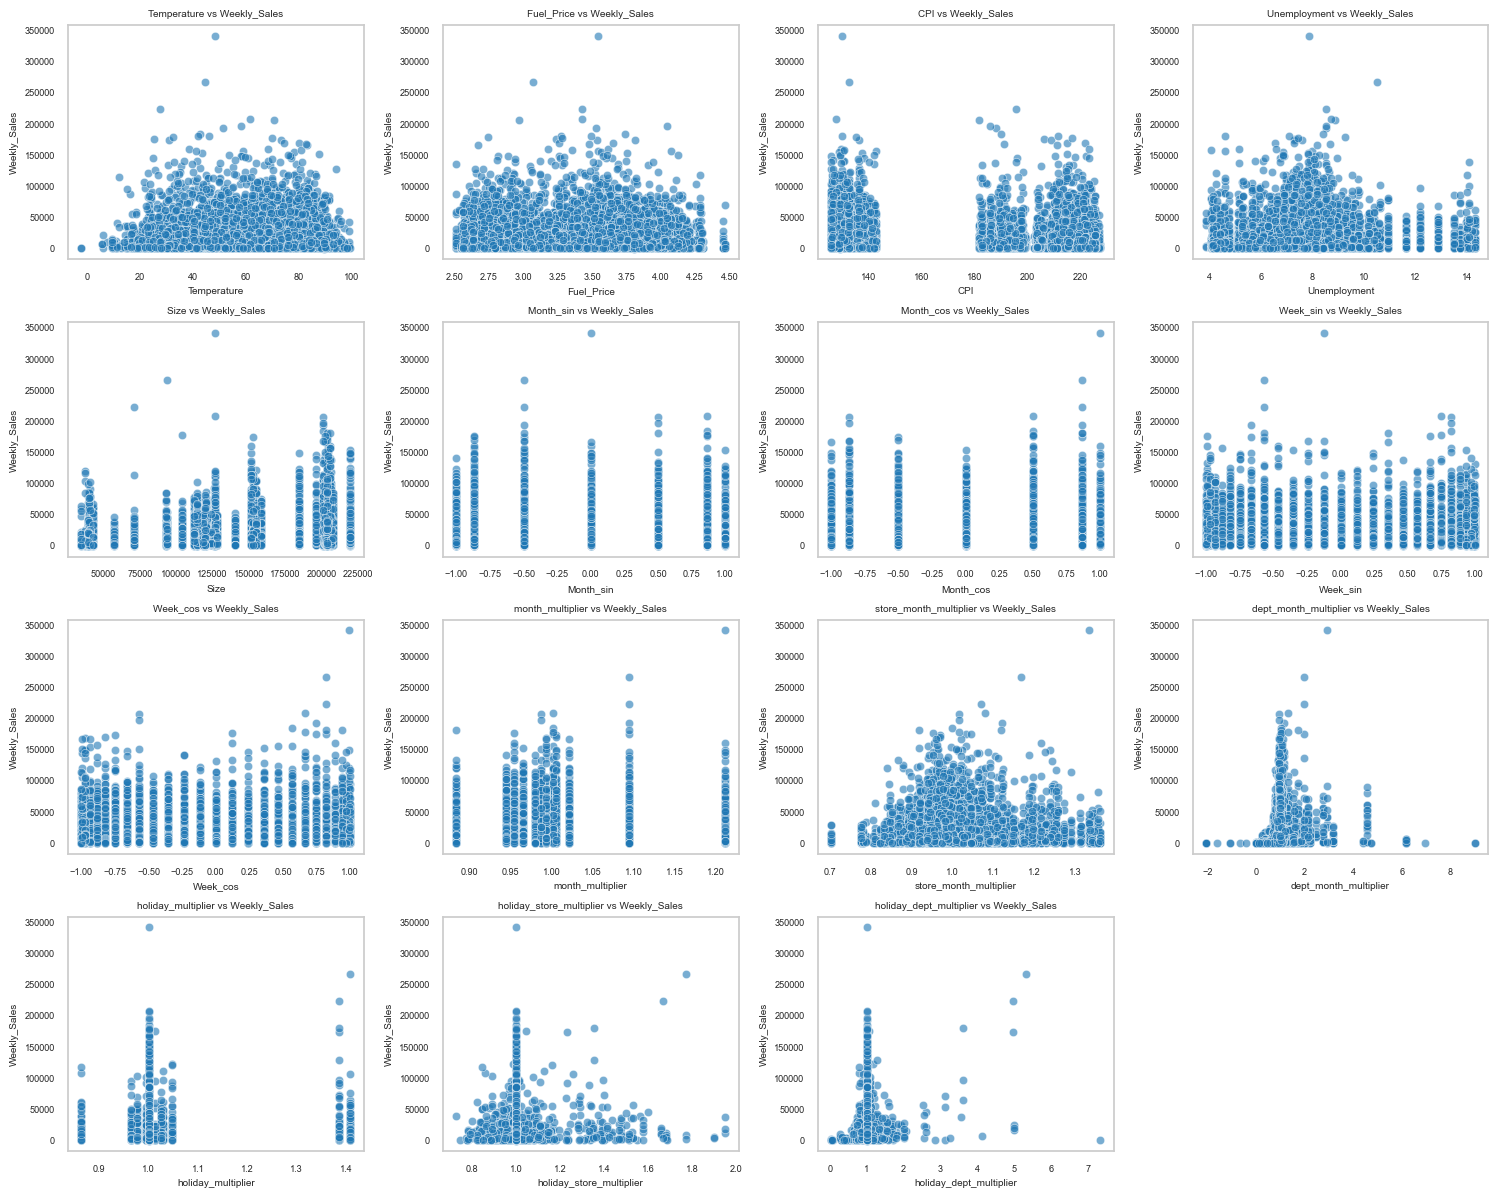

Column                  Test Name  P-value  Correlation  \
0                Temperature  Spearman Correlation Test   0.1522      -0.0143   
1                 Fuel_Price  Spearman Correlation Test   0.5494       0.0060   
2                        CPI  Spearman Correlation Test   0.0030      -0.0297   
3               Unemployment  Spearman Correlation Test   0.0708      -0.0181   
4                       Size  Spearman Correlation Test   0.0000       0.2956   
5                  Month_sin  Spearman Correlation Test   0.2559       0.0114   
6                  Month_cos  Spearman Correlation Test   0.7228      -0.0035   
7                   Week_sin  Spearman Correlation Test   0.1514       0.0143   
8                   Week_cos  Spearman Correlation Test   0.8422      -0.0020   
9           month_multiplier  Spearman Correlation Test   0.0002       0.0378   
10    store_month_multiplier  Spearman Correlation Test   0.0568       0.0190   
11     dept_month_multiplier  Spearman Correlation Test   0.0000       0.1614   
12        holiday_multiplier  Spearman Correlation Test   0.1670       0.0138   
13  holiday_store_multiplier  Spearman Correlation Test   0.6519       0.0045   
14   holiday_dept_multiplier  Spearman Correlation Test   0.0000       0.0412   

    Sample Size                   Significance Effect Magnitude  \
0         10000  Not statistically significant       negligible   
1         10000  Not statistically significant       negligible   
2         10000      Statistically significant       negligible   
3         10000  Not statistically significant       negligible   
4         10000      Statistically significant            small   
5         10000  Not statistically significant       negligible   
6         10000  Not statistically significant       negligible   
7         10000  Not statistically significant       negligible   
8         10000  Not statistically significant       negligible   
9         10000      Statistically significant       negligible   
10        10000  Not statistically significant       negligible   
11        10000      Statistically significant            small   
12        10000  Not statistically significant       negligible   
13        10000  Not statistically significant       negligible   
14        10000      Statistically significant       negligible   

   Correlation Direction  
0               Negative  
1               Positive  
2               Negative  
3               Negative  
4               Positive  
5               Positive  
6               Negative  
7               Positive  
8               Negative  
9               Positive  
10              Positive  
11              Positive  
12              Positive  
13              Positive  
14              Positive

In [47]:
for col in numerical_columns:
    results_num = numerical_predictor_significance_test(
        df=df,
        predictor=col,
        target=target_column,
    )
    df_significance_num = interpret_results_numerical(
        df_significance_num, results_num, col_name=col
    )

plot_continuous_relationships(
    df=df,
    predictors=numerical_columns,
    target=target_column,
)

df_significance_num

<div class="next-steps">
    <h3>Observations</h3>
    <p>Numerical predictors</p>
    <ol>
        <ul><code>Size</code>has a small effect magnitude, indicating that larger stores are usually more likely to generate higher sales volume. This is also shown in the chart, although some very small stores generate large sales as well</ul>
        <ul>At most, the retail store chain has about 1.4x more weekly sales during specific holidays; The rate gets higher for specific stores and departments</ul>
        <ul>Increased holiday sales are very-well shown as outliers in time-based features</ul>
        <ul>Out of the multipliers, only <code>dept_month_multiplier</code> has a non-negligible effect magnitude, indicating that some departments might be more season than holiday-driven</ul>
    </ol>
</div>

## Categorical predictors
We will exclude some high cardinality columns and temporarily convert boolean columns to string datatype.

In [48]:
df_significance_cat = pd.DataFrame()
categorical_columns = df.select_dtypes(exclude=[np.number]).columns

exclude_columns = [target_column]
chart_columns = [col for col in categorical_columns if col not in exclude_columns]

bool_cols = df[chart_columns].select_dtypes(include=["bool"]).columns
for col in bool_cols:
    df[col] = df[col].astype(str)

Sampled DataFrame size: (10000, 20)


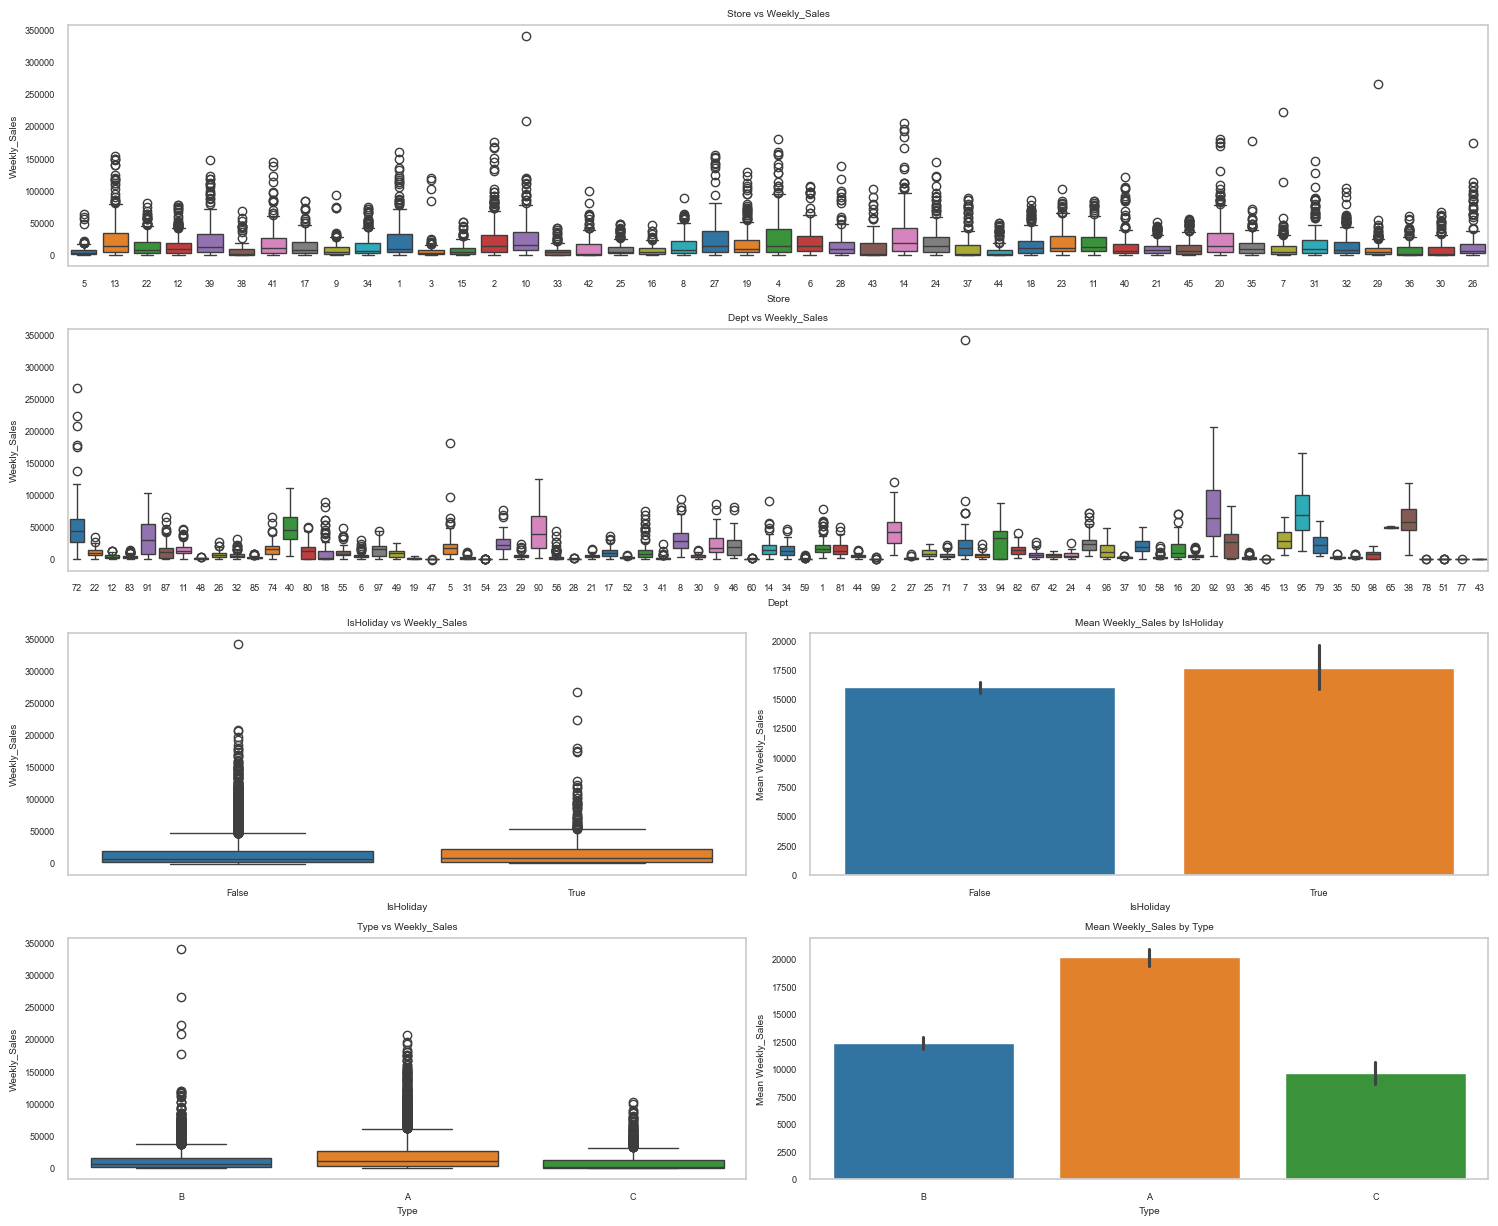

Column              Test Name  P-value  Test Statistic  \
0      Store  Kruskal-Wallis H-test   0.0000       1254.8000   
1       Dept  Kruskal-Wallis H-test   0.0000       5841.8600   
2  IsHoliday  Kruskal-Wallis H-test   0.3671          0.8100   
3       Type  Kruskal-Wallis H-test   0.0000        572.5400   

   Effect Size (eta-squared)                   Significance Effect Magnitude  
0                     0.0974      Statistically significant           medium  
1                     0.5643      Statistically significant            large  
2                     0.0003  Not statistically significant       negligible  
3                     0.0364      Statistically significant            small

In [49]:
for col in chart_columns:
    results_cat = categorical_predictor_significance_test(
        df, predictor=col, target=target_column
    )
    df_significance_cat = interpret_results_categorical(
        df_significance_cat, results_cat, col_name=col
    )
    
high_cardinality_predictors = ["Store", "Dept"]
plot_categorical_relationships(df, predictors=chart_columns,
                                high_cardinality_predictors=high_cardinality_predictors,
                                target=target_column)

df_significance_cat

In [50]:
for col in bool_cols:
    df[col] = df[col].astype("bool")

<div class="next-steps">
    <h3>Observations</h3>
    <p>Categorical predictors</p>
    <ol>
        <ul><code>Dept</code> has a large effect magnitude, indicating that some departments usually have higher weekly sales than others</ul>
        <ul>Features indicating holidays and markdowns are not statistically significant enough to state that sales differ between holidays and non-holidays</ul>
    </ol>
</div>

# Statistical Modeling
## Configuration
* **Data Split**:
  * Train - 2010-02-05 to 2012-06-10 (28 months)
  * Validation - 2012-06-10 to 2012-12-10 (6 months)
  * Forecast - 2012-12-10 to 2023-12-10 (1 year)
* **Data weighing** - dynamic weighing based on data age; Data older than 2012 loses 0.3 of weight for each subsequent year.
* **Performance Metric**: RMSE and MAPE
* **Models**:
    * XGBoost
    * GradientBoosting
    * LightGBM
    * CatBoost
    * ElasticNet
* **Baseline**: Result of the best performing model on the raw data.

**RMSE (Root Mean Square Error)** takes the square root of the average squared differences between predicted and actual values; It penalizes larger errors more heavily due to squaring.

**MAPE (Mean Absolute Percentage Error)** calculates the average percentage difference between predicted and actual values; It shows error as a percentage, making it scale-independent.

The data is split in the following periods:

In [51]:
print(f'Training data: {TRAIN_START} — {TRAIN_END}')
print(f'Validation data: {VALIDATION_START} — {VALIDATION_END}')
print(f'Forecasting data: {FORECAST_START} — {FORECAST_END}')

Training data: 2010-02-05 — 2012-06-10
Validation data: 2012-06-10 — 2012-12-10
Forecasting data: 2012-12-10 — 2013-12-10


Additionally, let's declare dates in the forecast period which are holiday weeks.

In [52]:
holiday_weeks = [
    '2012-12-28', # Christmas
    '2013-02-08', # Valentine's Day
    '2013-09-06', # Labor Day
    '2013-11-29', # Thanksgiving
]

Next, let's load the raw data we saved earlier and the store information dataset, and declare aggregation logic.

In [53]:
df_raw = pd.read_csv('exports/df_raw.csv')
df_stores = pd.read_csv('data/stores.csv')

# Convert date column to datetime
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# Drop redundant features that cannot be used in forecasting
df_raw = df_raw.drop(columns=['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], axis=1)

# Create an initial Forecast dataframe
df_forecast = create_forecast_dataframe(df_raw, df_stores, holiday_weeks,
                                        FORECAST_START, FORECAST_END)

# Aggregate the datasets to have store-level data
df = pd.concat([df_raw, df_forecast]).groupby(['Store', 'Date']).agg({
    'Weekly_Sales': 'sum',
    'IsHoliday': 'max',
    'Type': 'first',
    'Size': 'first'
}).reset_index()

Finally, let's create a function to initialize the models we will be using.

In [54]:
models = {
    'xgboost': XGBRegressor(
        random_state=RANDOM_STATE,
    ),
    'gradient_boosting': GradientBoostingRegressor(
        random_state=RANDOM_STATE,
    ),
    'lightgbm': LGBMRegressor(
        random_state=RANDOM_STATE,
        verbose=-1,
    ),
    'catboost': CatBoostRegressor(
        verbose=False,
        random_state=RANDOM_STATE,
    ),
    'elasticnet': ElasticNet(
        random_state=RANDOM_STATE,
    )
}

## Model Baseline
Let's set the performance baseline. We will look at the performance of both chain-level performance and store-level performance to see if there is a marginal difference.

Model name: xgboost
Training time: 2.03 seconds


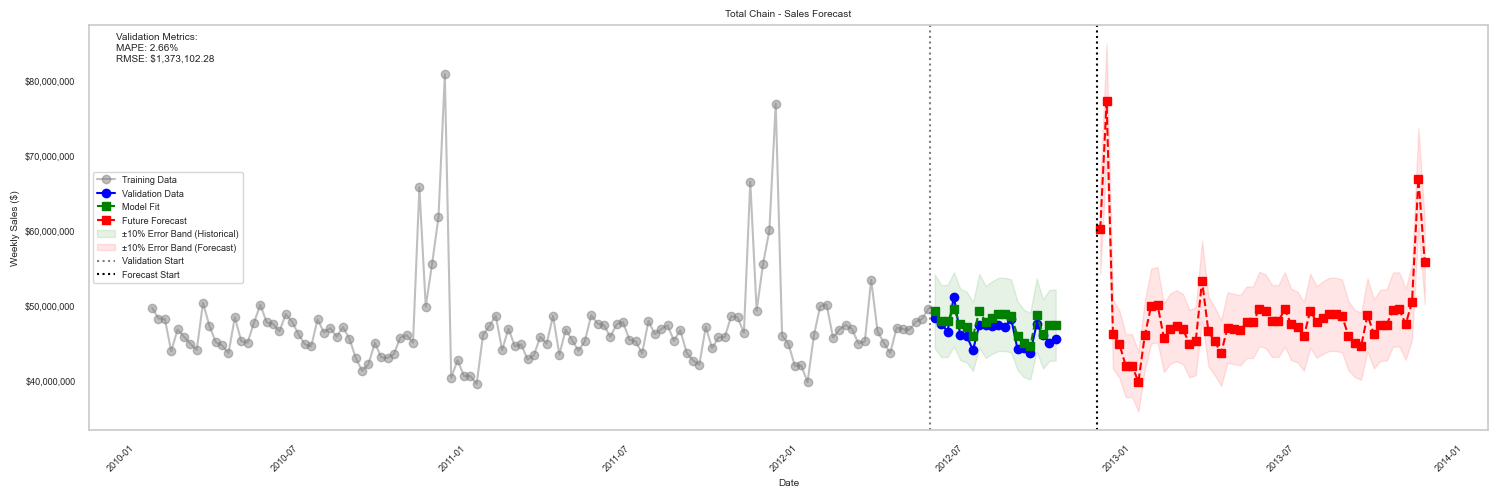

Model name: gradient_boosting
Training time: 1.51 seconds


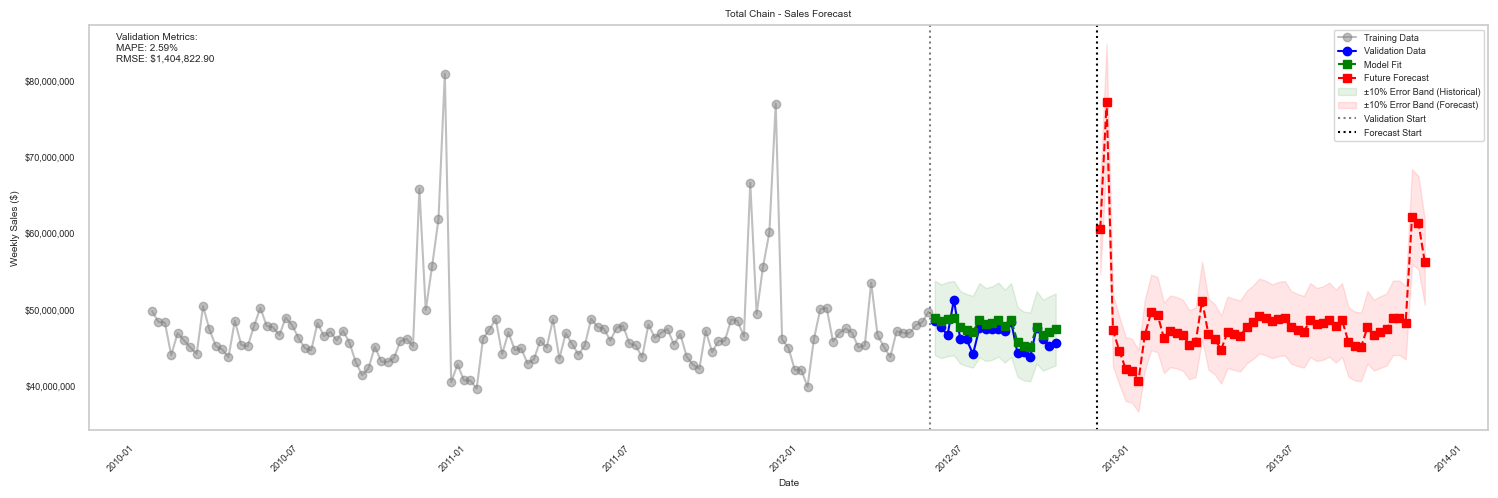

Model name: lightgbm
Training time: 0.67 seconds


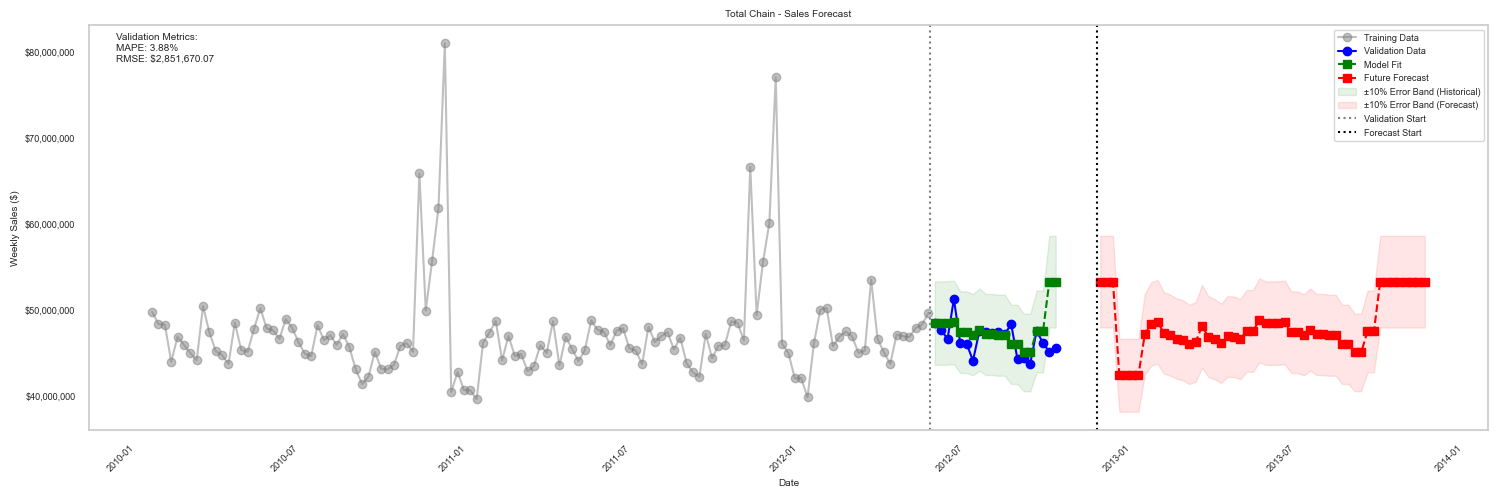

Model name: catboost
Training time: 18.00 seconds


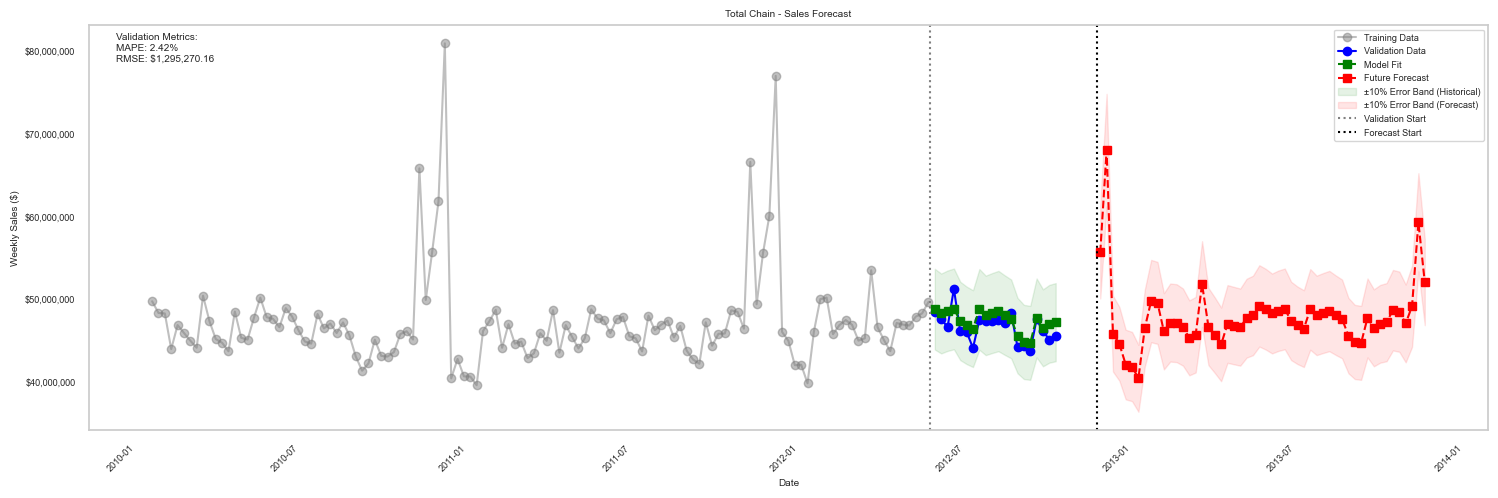

Model name: elasticnet
Training time: 0.34 seconds


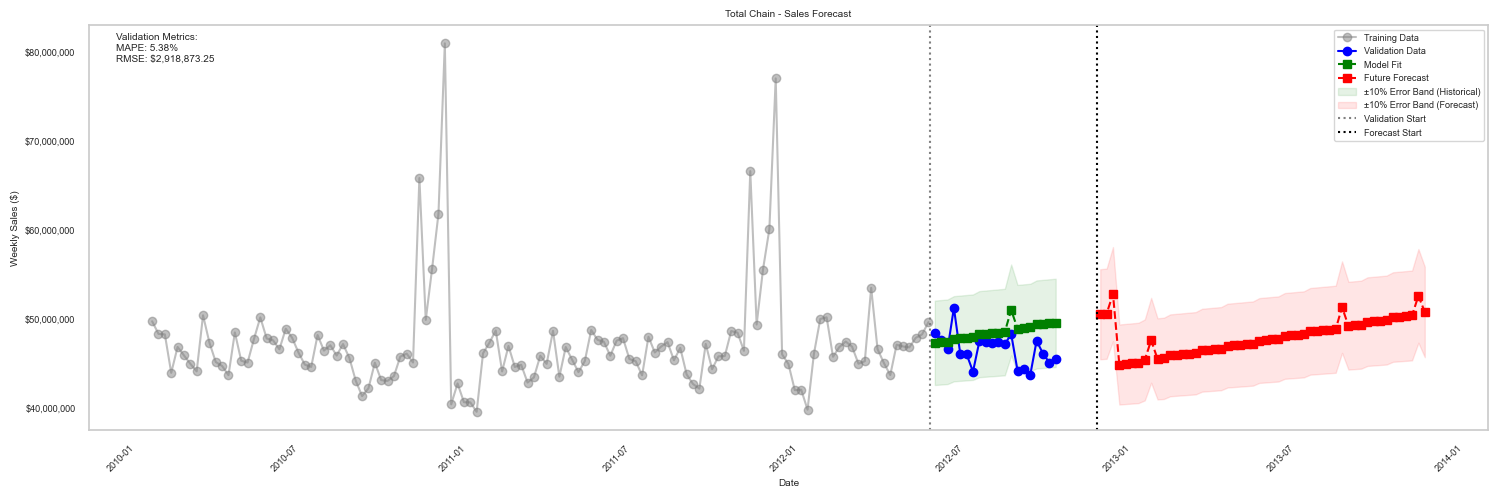

In [55]:
df_performance = pd.DataFrame(columns=['Model'])
for model_name in models:
    next_idx = len(df_performance)
    df_performance.loc[next_idx] = [model_name]

df_performance = train_and_plot_model_results(df, models, df_performance, trial_name='Baseline')

In [56]:
print("Store-level aggregated model performance:")
df_performance

Store-level aggregated model performance:


Model  MAPE_Baseline  RMSE_Baseline
0            xgboost         0.0266   1373102.0000
1  gradient_boosting         0.0259   1404822.0000
2           lightgbm         0.0388   2851670.0000
3           catboost         0.0242   1295270.0000
4         elasticnet         0.0538   2918873.0000

Store-level aggregated model performance is better throughout all models except for catboost, but the results do not differ significantly, which indicates that we did not make critical mistakes when splitting & aggregating the data.

On the retail chain level, the current best result is `catboost` with a **MAPE** of 0.0193 and **RMSE** of 1,131,666. We will use these scores as a baseline.

<div class="next-steps">
    <h3>Observations</h3>
    <p>Model Performance - Raw Dataset</p>
    <ol>
        <ul><code>ElasticNet</code> and <code>LightGBM</code> seem to have peculiar forecasts, not resembling past data</ul>
        <ul><code>XGBoost</code>, <code>GradientBoosting</code> and <code>CatBoost</code> models have similar and believable forecast shapes with similar performance results</ul>
    </ol>
</div>

## Model Performance - Feature Engineering
Next, let's check the performance of the model with feature engineering implemented. The feature engineering part includes:
* Time-based cyclical features - Week and Month `_sin` and `_cos` calculations
* Time-based multipliers:
  * Seasonal multipliers - based on average sales during a specific week/month
  * Holiday multipliers - based on sales during a holiday week

The forecast dataframe will inherit the last multipliers for the specific store and calendar week. Time-based cyclical features will be calculated independently.

In [57]:
df_raw = pd.read_csv('exports/df_raw.csv')
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
df_raw = df_raw.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
                            'MarkDown5', 'markdown_available',
                            'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], axis=1)

First, create the features on the raw dataset and create a forecast dataframe.

In [58]:
df = create_forecast_features(df_raw)
df_forecast = create_forecast_dataframe(df, df_stores, holiday_weeks,
                                        FORECAST_START, FORECAST_END)

Next, create & inherit some of the features to the forecast dataframe.

In [59]:
# Time features
df_forecast['Month_sin'] = np.sin(2 * np.pi * df_forecast['Date'].dt.month / 12)
df_forecast['Month_cos'] = np.cos(2 * np.pi * df_forecast['Date'].dt.month / 12)
df_forecast['Week_sin'] = np.sin(2 * np.pi * df_forecast['Date'].dt.isocalendar().week / 52)
df_forecast['Week_cos'] = np.cos(2 * np.pi * df_forecast['Date'].dt.isocalendar().week / 52)

# Get multipliers data
last_multipliers = df.groupby(['Store', 'Dept', 'Week_sin']).agg({
    'month_multiplier': 'last',
    'store_month_multiplier': 'last',
    'dept_month_multiplier': 'last',
    'holiday_multiplier': 'last',
    'holiday_store_multiplier': 'last',
    'holiday_dept_multiplier': 'last'
}).reset_index().fillna(1)

# Merge multipliers to forecast
df_forecast = df_forecast.merge(
    last_multipliers,
    on=['Store', 'Dept', 'Week_sin'],
    how='left'
).fillna(1)

In [60]:
df = pd.concat([df, df_forecast]).groupby(['Store', 'Date']).agg({
    'Weekly_Sales': 'sum',
    'IsHoliday': 'max',
    'Type': 'first',
    'Size': 'first',
    'Month_sin': 'max',
    'Month_cos': 'max',
    'Week_sin': 'max',
    'Week_cos': 'max',
    'month_multiplier': 'max',
    'store_month_multiplier': 'max',
    'dept_month_multiplier': 'sum',
    'holiday_multiplier': 'max',
    'holiday_store_multiplier': 'max',
    'holiday_dept_multiplier': 'max',
}).reset_index()

Model name: xgboost
Training time: 2.25 seconds


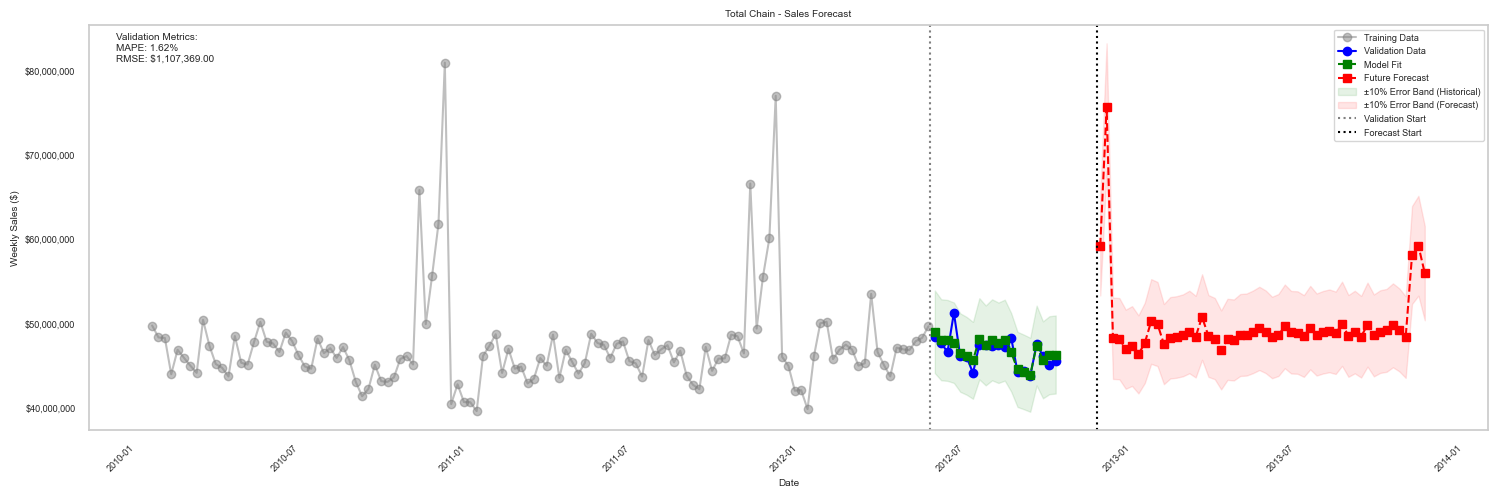

Model name: gradient_boosting
Training time: 1.89 seconds


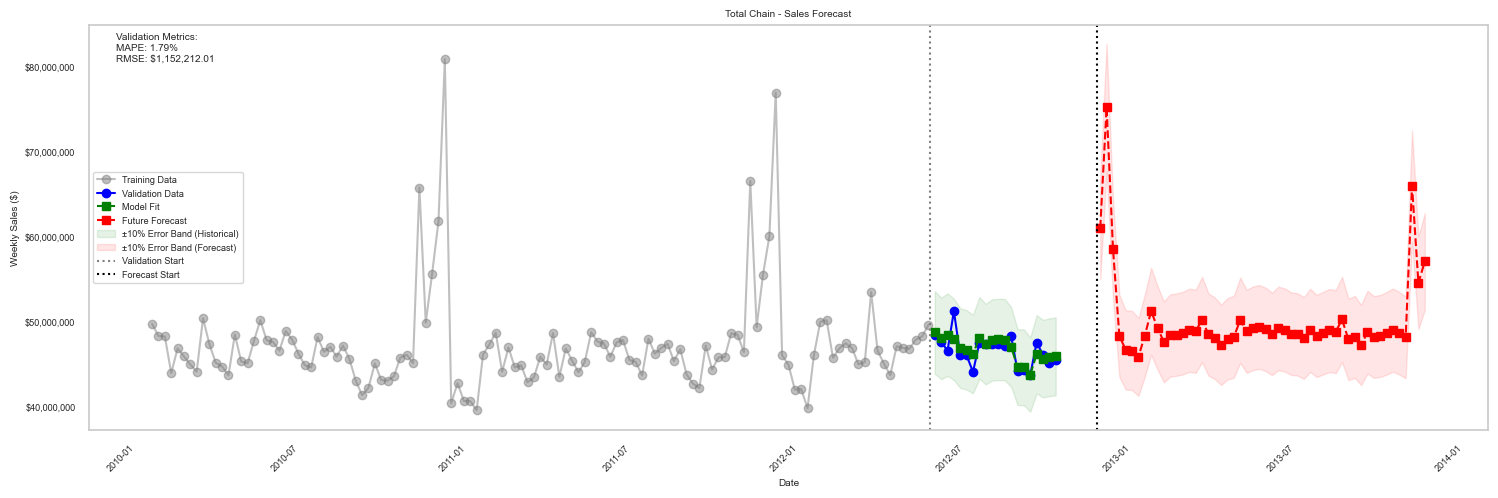

Model name: lightgbm
Training time: 0.63 seconds


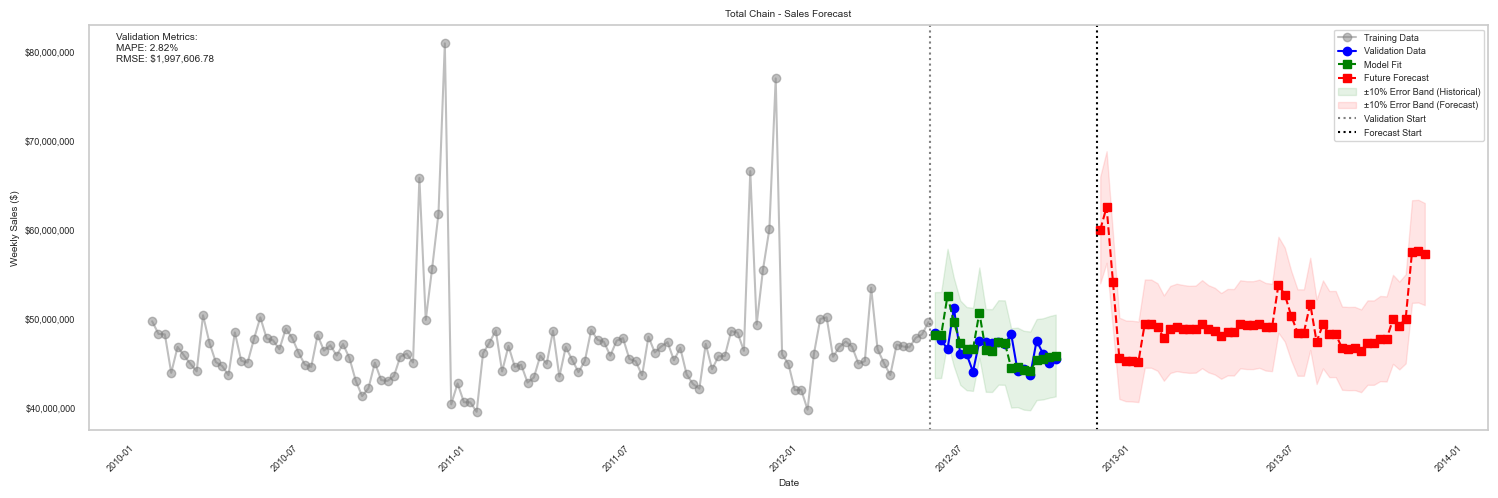

Model name: catboost
Training time: 23.94 seconds


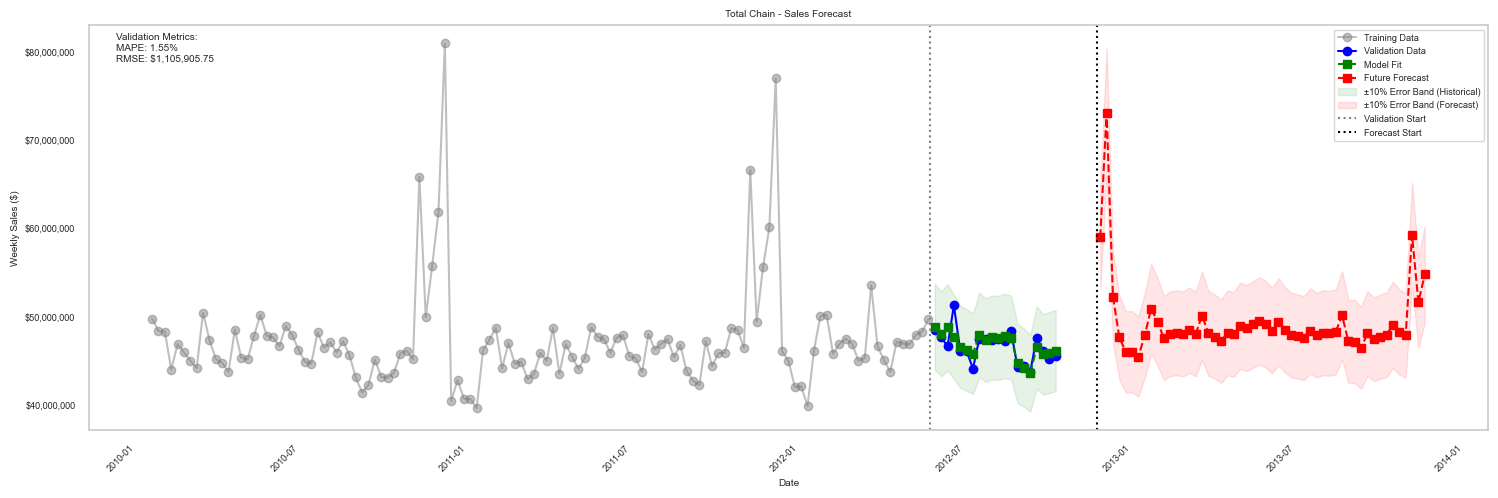

Model name: elasticnet
Training time: 0.42 seconds


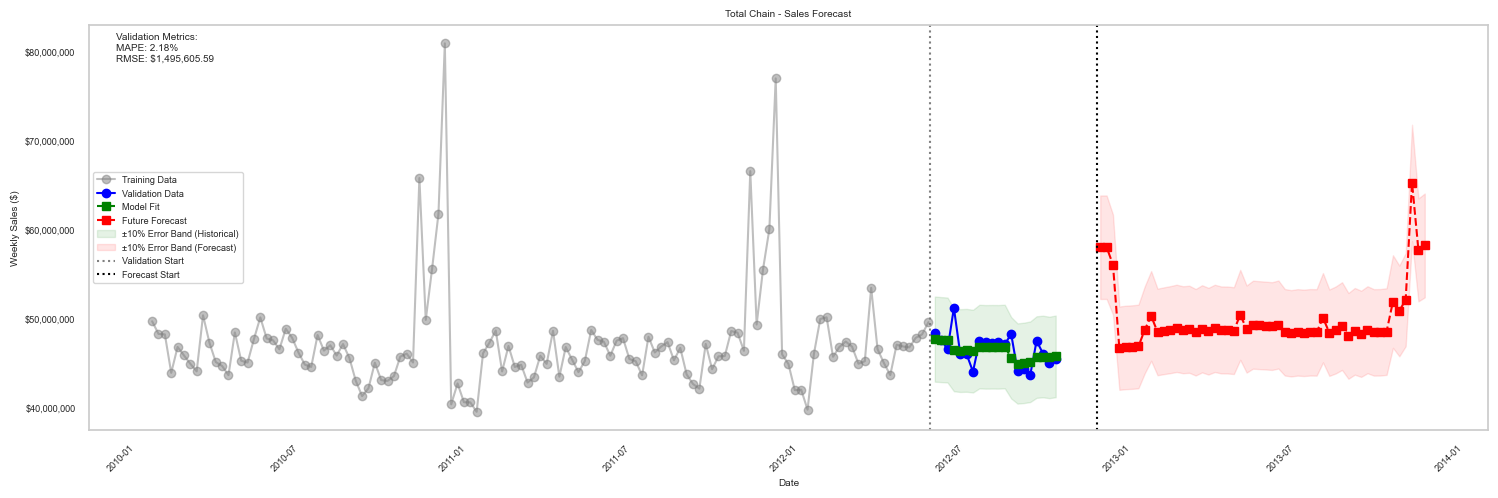

Model  MAPE_Baseline  RMSE_Baseline  MAPE_FE      RMSE_FE
0            xgboost         0.0266   1373102.0000   0.0162 1107368.0000
1  gradient_boosting         0.0259   1404822.0000   0.0179 1152212.0000
2           lightgbm         0.0388   2851670.0000   0.0282 1997606.0000
3           catboost         0.0242   1295270.0000   0.0155 1105905.0000
4         elasticnet         0.0538   2918873.0000   0.0218 1495605.0000

In [61]:
train_and_plot_model_results(df, models, df_performance, trial_name='FE')

In [62]:
df_performance

Model  MAPE_Baseline  RMSE_Baseline  MAPE_FE      RMSE_FE
0            xgboost         0.0266   1373102.0000   0.0162 1107368.0000
1  gradient_boosting         0.0259   1404822.0000   0.0179 1152212.0000
2           lightgbm         0.0388   2851670.0000   0.0282 1997606.0000
3           catboost         0.0242   1295270.0000   0.0155 1105905.0000
4         elasticnet         0.0538   2918873.0000   0.0218 1495605.0000

<div class="next-steps">
    <h3>Observations</h3>
    <p>Model Performance - Feature Engineering</p>
    <ol>
        <ul>All models saw a significant improvement in store-level and retail chain performance, in both MAPE and RMSE</ul>
        <ul>At retail chain level, MAPE decreased by an average of 36%</ul>
        <ul>At retail chain level, RMSE decreased by an average of 27%</ul>
        <ul><code>GradientBoosting</code> has the best MAPE, at 0.0142</ul>
        <ul><code>CatBoost</code> has the best RSME, at 1,096,055</ul>
        <ul>Feature Engineering has improved the predictive power of <code>LightGBM</code> and <code>ElasticNet</code> models</ul>
    </ol>
</div>

## Model Performance - Model Tuning with Optuna
Next, let's tune the models with Optuna.

We will do model tuning on data aggregated at `Date` level (retail chain-based), since otherwise we would have to create a separate model for each store, which would be difficult to manage and take up much more computational resources and time. Nontheless, this option will be included in Opportunities.

In [63]:
X_train, y_train, X_val, y_val, feature_cols, train_weights = prepare_chain_data_for_tuning(df)

Next, let's define the parameter grids for each model.

In [64]:
def get_model_params(trial, model_name):
    if model_name == 'xgboost':
        return {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
            'objective': 'reg:squarederror'
        }

    elif model_name == 'lightgbm':
        return {
            'num_leaves': trial.suggest_int('num_leaves', 20, 128),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
            'feature_fraction_seed': trial.suggest_int('feature_fraction_seed', 1, 100)
        }

    elif model_name == 'elasticnet':
        return {
            'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log=True),
            'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0),
            'max_iter': 3000,
            'tol': trial.suggest_float('tol', 1e-5, 1e-3, log=True)
        }

    elif model_name == 'gradient_boosting':
        return {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_categorical('max_depth', [None] + list(range(3, 13))),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'alpha': trial.suggest_float('alpha', 1e-5, 0.1, log=True)
        }

    elif model_name == 'catboost':
        return {
            'iterations': trial.suggest_int('iterations', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
            'max_bin': trial.suggest_int('max_bin', 200, 400),
            'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0, log=True),
            'od_type': 'Iter',
            'od_wait': trial.suggest_int('od_wait', 20, 50)
        }
    else:
        raise ValueError(f"Unknown model type: {model_name}")

Define the objective and tuning functions.

In [65]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(model_name, trial, X_train, y_train, X_val, y_val, train_weights, metric):
    params = get_model_params(trial, model_name)
    if model_name == 'xgboost':
        model = XGBRegressor(**params, random_state=RANDOM_STATE)
    elif model_name == 'lightgbm':
        model = LGBMRegressor(**params, random_state=RANDOM_STATE, verbose=-1)
    elif model_name == 'elasticnet':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        model = ElasticNet(**params, random_state=RANDOM_STATE)
    elif model_name == 'gradient_boosting':
        model = GradientBoostingRegressor(**params, random_state=RANDOM_STATE)
    elif model_name == 'catboost':
        model = CatBoostRegressor(**params, random_state=RANDOM_STATE, verbose=False)
    else:
        raise ValueError(f"Unknown model: {model_name}")
        
    model.fit(X_train, y_train, sample_weight=train_weights)
    preds = model.predict(X_val)
    
    if metric == 'rmse':
        result = np.sqrt(mean_squared_error(y_val, preds))
    elif metric == 'mape':
        result = mean_absolute_percentage_error(y_val, preds)
    
    return result

def tune_model(model_name, X_train, y_train, X_val, y_val, train_weights, n_trials=100, metric='mape'):
    print(f'\nTuning model: {model_name}')
    start_time = time.time()
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=RANDOM_STATE)
    )
    
    study.optimize(
        lambda trial: objective(model_name, trial, X_train, y_train, X_val, y_val, train_weights, metric),
        n_trials=n_trials,
        show_progress_bar=True
    )
    
    best_params = study.best_params
    
    if model_name == 'xgboost':
        best_model = XGBRegressor(**best_params, random_state=RANDOM_STATE)
    elif model_name == 'lightgbm':
        best_model = LGBMRegressor(**best_params, random_state=RANDOM_STATE, verbose=-1)
    elif model_name == 'elasticnet':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        best_model = ElasticNet(**best_params, random_state=RANDOM_STATE)
    elif model_name == 'gradient_boosting':
        best_model = GradientBoostingRegressor(**best_params, random_state=RANDOM_STATE)
    elif model_name == 'catboost':
        best_model = CatBoostRegressor(**best_params, random_state=RANDOM_STATE, verbose=False)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    best_model.fit(X_train, y_train, sample_weight=train_weights)
    end_time = time.time()
    training_time = end_time - start_time
    print(f'Model tuned in {training_time:.2f} seconds.')
    
    return best_model, best_params, study

Finally, tune the models. We will use 300 iterations for all models except `CatBoost`, which will have 100.

In [66]:
best_models = {}
for model_name in models:
    if TUNE_MODELS:
        # Tune the models through Optuna trials
        if model_name == 'catboost':
            n_trials = 100
        else:
            n_trials = 300
        model, params, study = tune_model(model_name, X_train, y_train,
                                            X_val, y_val, train_weights,
                                            n_trials=n_trials, metric='mape')
        joblib.dump(model, f'models/{model_name}_tuned.joblib')
    else:
        # Alternatively, load the already tuned models
        model = joblib.load(f'models/{model_name}_tuned.joblib')
    best_models[model_name] = model

Model name: xgboost
Training time: 10.69 seconds


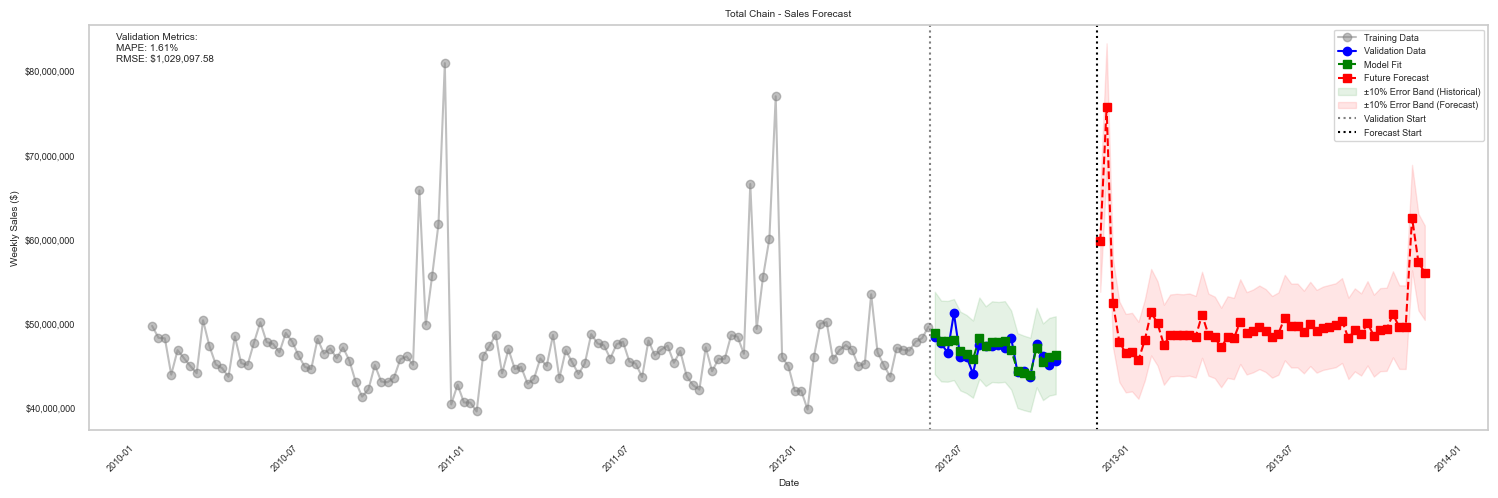

Model name: gradient_boosting
Training time: 8.66 seconds


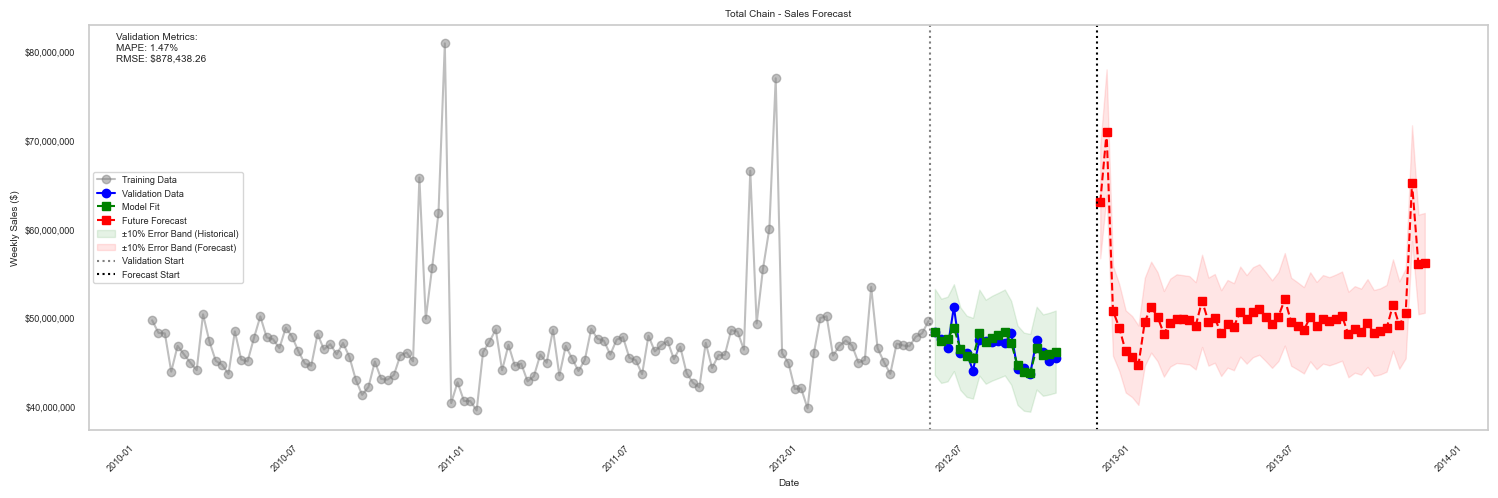

Model name: lightgbm
Training time: 4.55 seconds


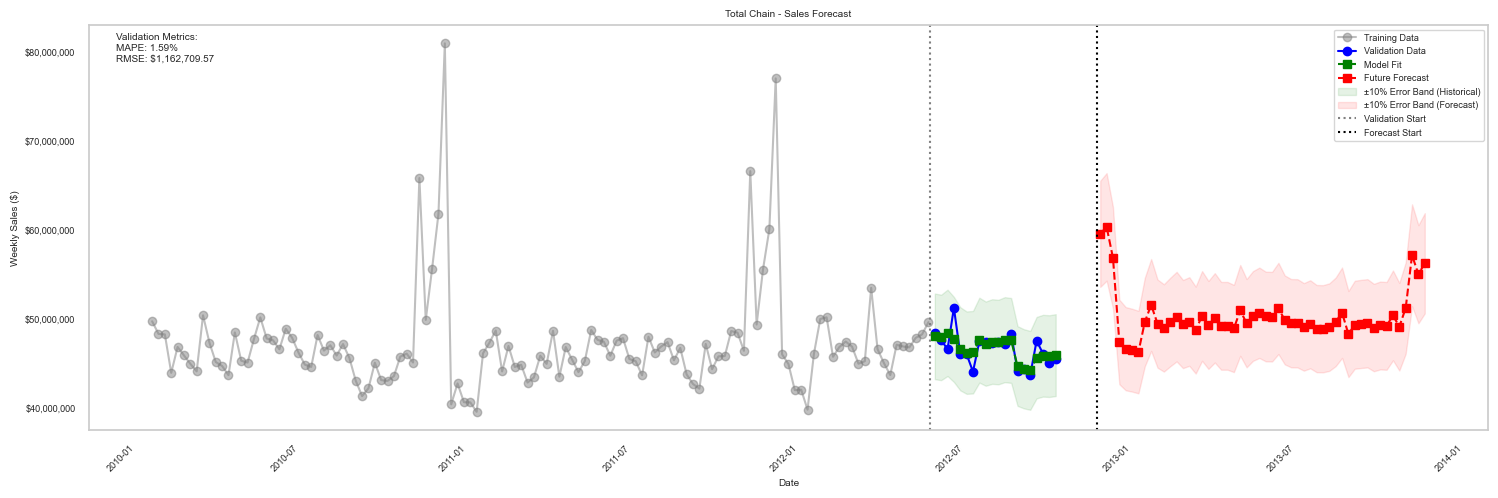

Model name: catboost
Training time: 83.41 seconds


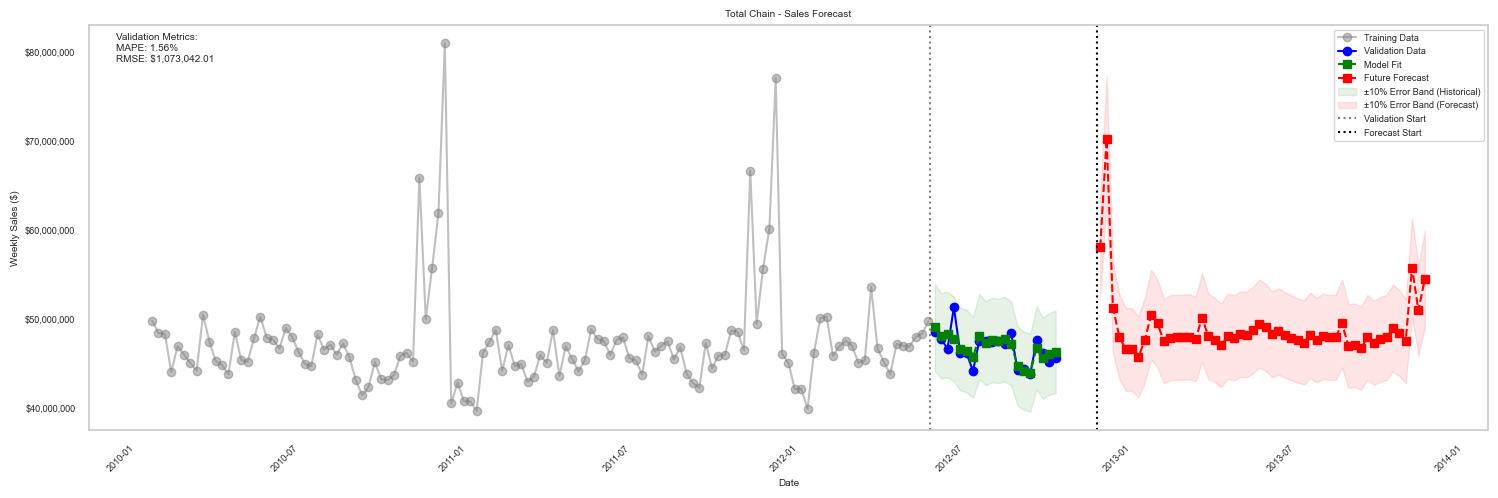

Model name: elasticnet
Training time: 0.41 seconds


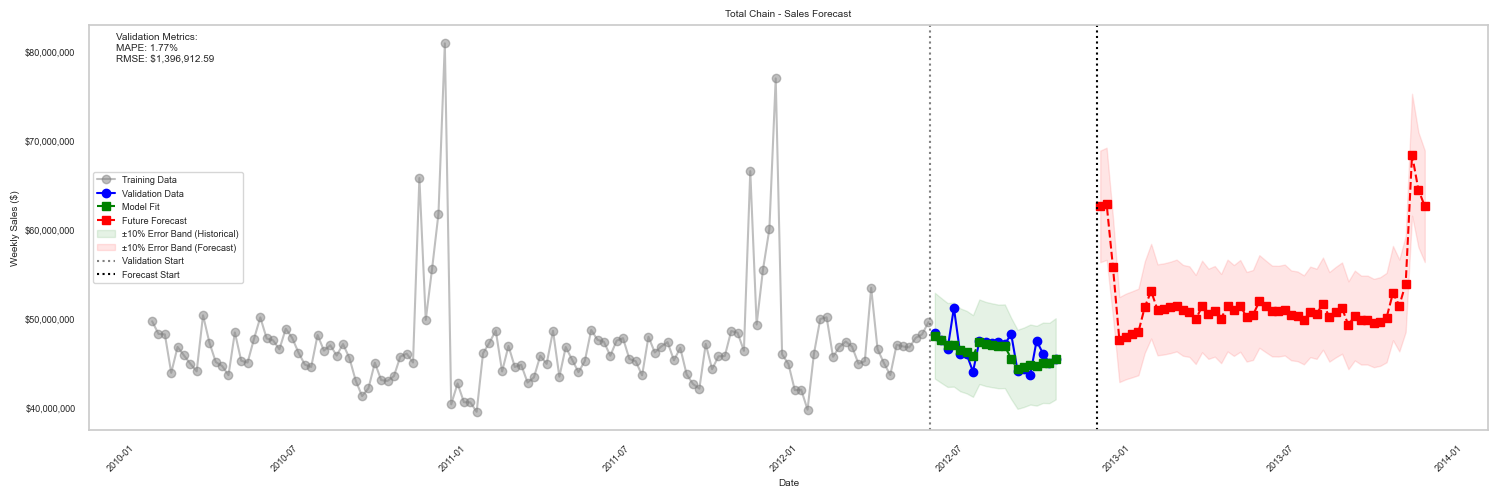

Model  MAPE_Baseline  RMSE_Baseline  MAPE_FE      RMSE_FE  \
0            xgboost         0.0266   1373102.0000   0.0162 1107368.0000   
1  gradient_boosting         0.0259   1404822.0000   0.0179 1152212.0000   
2           lightgbm         0.0388   2851670.0000   0.0282 1997606.0000   
3           catboost         0.0242   1295270.0000   0.0155 1105905.0000   
4         elasticnet         0.0538   2918873.0000   0.0218 1495605.0000   

   MAPE_Tuned   RMSE_Tuned  
0      0.0161 1029097.0000  
1      0.0147  878438.0000  
2      0.0159 1162709.0000  
3      0.0156 1073042.0000  
4      0.0177 1396912.0000

In [67]:
train_and_plot_model_results(df, best_models, df_performance, trial_name='Tuned')

In [68]:
df_performance

Model  MAPE_Baseline  RMSE_Baseline  MAPE_FE      RMSE_FE  \
0            xgboost         0.0266   1373102.0000   0.0162 1107368.0000   
1  gradient_boosting         0.0259   1404822.0000   0.0179 1152212.0000   
2           lightgbm         0.0388   2851670.0000   0.0282 1997606.0000   
3           catboost         0.0242   1295270.0000   0.0155 1105905.0000   
4         elasticnet         0.0538   2918873.0000   0.0218 1495605.0000   

   MAPE_Tuned   RMSE_Tuned  
0      0.0161 1029097.0000  
1      0.0147  878438.0000  
2      0.0159 1162709.0000  
3      0.0156 1073042.0000  
4      0.0177 1396912.0000

<div class="next-steps">
    <h3>Observations</h3>
    <p>Model Performance - Model Tuning</p>
    <ol>
        <ul>All models saw a significant improvement in performance from Model Tuning at chain level.</ul>
        <ul><code>GradientBoosting</code> has the best RMSE and MAPE scores</ul>
        <ul><code>ElasticNet</code> is the worst performer</ul>
    </ol>
</div>

## Model Ensembling
Let's create ensemble models to leverage the strengths of individual models and boost performance. We will use the tuned models, except for `CatBoost`, as it has similar performance to other models, yet takes much more time to train.

First, let's store the models in a separate dict.

Retrieve the predictions of all models.

In [69]:
ensemble_models = {}
for model_name, model in best_models.items():
    if model_name != 'catboost':
        ensemble_models[model_name] = model

predictions = np.column_stack([
    cross_val_predict(model, X_train, y_train, cv=None)
    for _, model in ensemble_models.items() 
])

Additionally, let's retrieve the MAPE and RMSE scores for each model.

In [70]:
MAPE_scores = {}
RMSE_scores = {}
for model_name, model in ensemble_models.items():
    results_chain = forecast_chain_sales(
        df,
        model,
        model_name
    )

    score_MAPE_chain = round(results_chain['chain_metrics']['MAPE'], 6)
    score_RMSE_chain = int(results_chain['chain_metrics']['RMSE'])

    MAPE_scores[model_name] = score_MAPE_chain
    RMSE_scores[model_name] = score_RMSE_chain

### Weighted Blending
In this approach, we will assign weights to each model based on their RMSE performance. Lower RMSE models will get a higher weight.

In [71]:
# Calculate weights
rmse = np.array([RMSE_score for RMSE_score in RMSE_scores.values()])
weights = 1 / rmse
weights = weights / np.sum(weights)

# Create estimators
estimators = [(model_name, model) for model_name, model in ensemble_models.items()]

# Define model
weighted_blending_model = VotingRegressor(
    estimators=estimators,
    weights=weights.tolist(),
    n_jobs=-1
)

weighted_blending_model

VotingRegressor(estimators=[('xgboost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.855099980208038,
                                          device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=0.23086499149995468,
                                          grow_policy=None,
                                          importance_type=None,
                                          interactio...
                                           n_estimators=776, num_leaves=112,
                                           random_state=98,
                                           reg_alpha=0.0016963910094893056,
                                           reg_lambda=1.244120357099521,
                                           subsample=0.9977254217268695,
                                           verbose=-1)),
                            ('elasticnet',
                             ElasticNet(alpha=0.021782988653661225,
                                        l1_ratio=0.3666277695300948,
                                        random_state=98,
                                        tol=0.0008262753567799677))],
                n_jobs=-1,
                weights=[0.26884744309503844, 0.3347028255835799,
                         0.22184465962367175, 0.17460507169770986])

### Stacking Regressor
#### Ridge meta-learner
Create a `StackingRegressor` which uses `RidgeRegression` as the meta-learner.

In [72]:
ridge_stacking_model = StackingRegressor(
        estimators=estimators,
        final_estimator=Ridge(),
        cv=None,
        n_jobs=-1,
        passthrough=False
    )

ridge_stacking_model

StackingRegressor(estimators=[('xgboost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.855099980208038,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.23086499149995468,
                                            grow_policy=None,
                                            importance_type=None,
                                            interact...
                                             max_depth=7, min_child_samples=5,
                                             min_child_weight=0.21091318879463744,
                                             n_estimators=776, num_leaves=112,
                                             random_state=98,
                                             reg_alpha=0.0016963910094893056,
                                             reg_lambda=1.244120357099521,
                                             subsample=0.9977254217268695,
                                             verbose=-1)),
                              ('elasticnet',
                               ElasticNet(alpha=0.021782988653661225,
                                          l1_ratio=0.3666277695300948,
                                          random_state=98,
                                          tol=0.0008262753567799677))],
                  final_estimator=Ridge(), n_jobs=-1)

#### GradientBoosting meta-learner
Create a `StackingRegressor` which uses the best-performing `GradientBoosting` tuned model as the meat-learner.

In [73]:
estimators_ex_gb = [
    (model_name, model) 
    for model_name, model in ensemble_models.items() 
    if model_name != 'gradient_boosting'
]

gb_stacking_model = StackingRegressor(
        estimators=estimators_ex_gb,
        final_estimator=best_models['gradient_boosting'],
        cv=None,
        n_jobs=-1,
        passthrough=False
    )

gb_stacking_model

StackingRegressor(estimators=[('xgboost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.855099980208038,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.23086499149995468,
                                            grow_policy=None,
                                            importance_type=None,
                                            interact...
                               ElasticNet(alpha=0.021782988653661225,
                                          l1_ratio=0.3666277695300948,
                                          random_state=98,
                                          tol=0.0008262753567799677))],
                  final_estimator=GradientBoostingRegressor(alpha=6.820273616470685e-05,
                                                            learning_rate=0.05125955484153085,
                                                            max_depth=None,
                                                            max_features=0.5316006112100926,
                                                            min_samples_leaf=5,
                                                            min_samples_split=19,
                                                            n_estimators=510,
                                                            random_state=98,
                                                            subsample=0.6774464961892624),
                  n_jobs=-1)

### Multi-level Stacking
Implement a two-level stacking ensemble with `Lasso` as the final estimator.

In [74]:
# Define groups of models
n_models = len(best_models)
mid_point = n_models // 2
group1_estimators = estimators[:mid_point]
group2_estimators = estimators[mid_point:]

stack1 = StackingRegressor(
        estimators=group1_estimators,
        final_estimator=Lasso(alpha=0.01),
        n_jobs=-1,
        passthrough=False
)

stack2 = StackingRegressor(
    estimators=group2_estimators,
    final_estimator=Lasso(alpha=0.01),
    n_jobs=-1,
    passthrough=False
)

final_estimators = [
    ('stack1', stack1),
    ('stack2', stack2)
]

multilevel_stacking_model = StackingRegressor(
    estimators=final_estimators,
    final_estimator=Lasso(alpha=0.01),
    n_jobs=-1,
    passthrough=False
)

multilevel_stacking_model

StackingRegressor(estimators=[('stack1',
                               StackingRegressor(estimators=[('xgboost',
                                                              XGBRegressor(base_score=None,
                                                                           booster=None,
                                                                           callbacks=None,
                                                                           colsample_bylevel=None,
                                                                           colsample_bynode=None,
                                                                           colsample_bytree=0.855099980208038,
                                                                           device=None,
                                                                           early_stopping_rounds=None,
                                                                           enable_categorical=False,
                                                                           eval_metric=None,
                                                                           feature_types=None,
                                                                           gamma=0.23086499149995468,
                                                                           grow_p...
                                                                            num_leaves=112,
                                                                            random_state=98,
                                                                            reg_alpha=0.0016963910094893056,
                                                                            reg_lambda=1.244120357099521,
                                                                            subsample=0.9977254217268695,
                                                                            verbose=-1)),
                                                             ('elasticnet',
                                                              ElasticNet(alpha=0.021782988653661225,
                                                                         l1_ratio=0.3666277695300948,
                                                                         random_state=98,
                                                                         tol=0.0008262753567799677))],
                                                 final_estimator=Lasso(alpha=0.01),
                                                 n_jobs=-1))],
                  final_estimator=Lasso(alpha=0.01), n_jobs=-1)

Let's benchmark all the ensemble models.

In [75]:
ensemble_models = {
    'weighted_blending': weighted_blending_model,
    'ridge stacking': ridge_stacking_model,
    'gradient_boosting stacking': gb_stacking_model,
    'multilevel stacking': multilevel_stacking_model
}

Model name: weighted_blending
Training time: 17.97 seconds


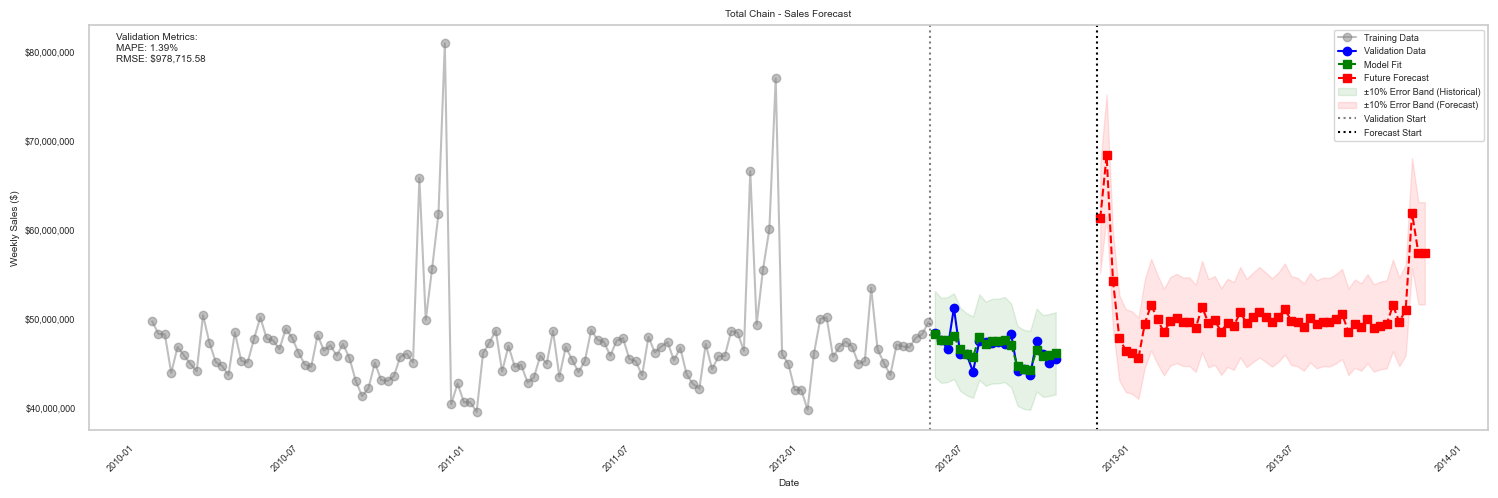

Model name: ridge stacking
Training time: 68.51 seconds


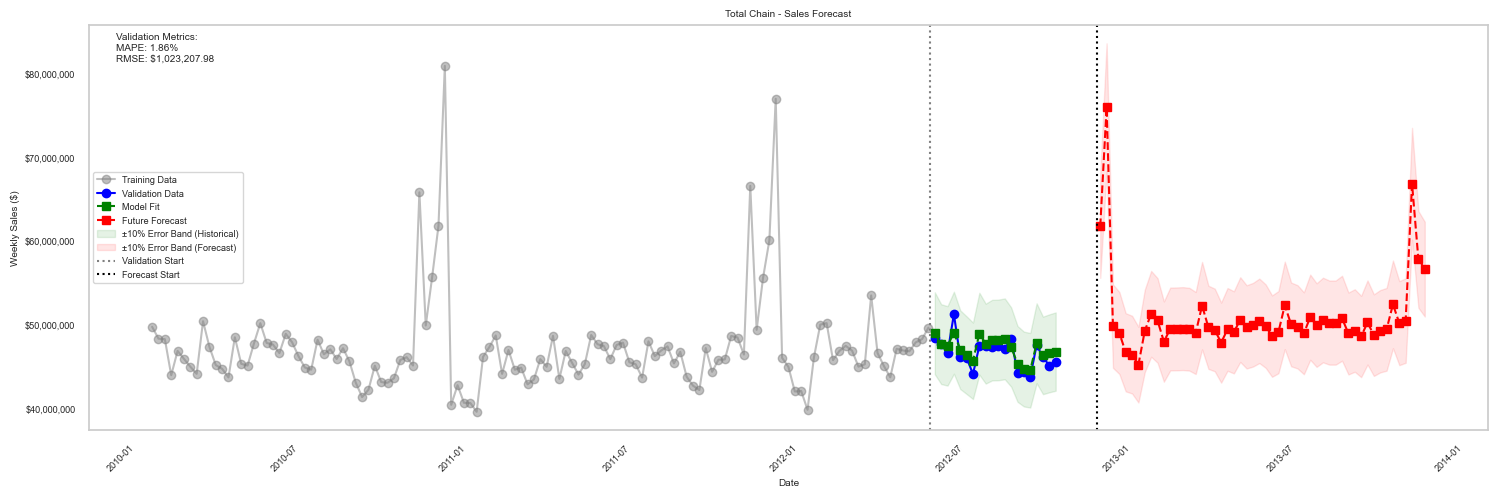

Model name: gradient_boosting stacking
Training time: 46.08 seconds


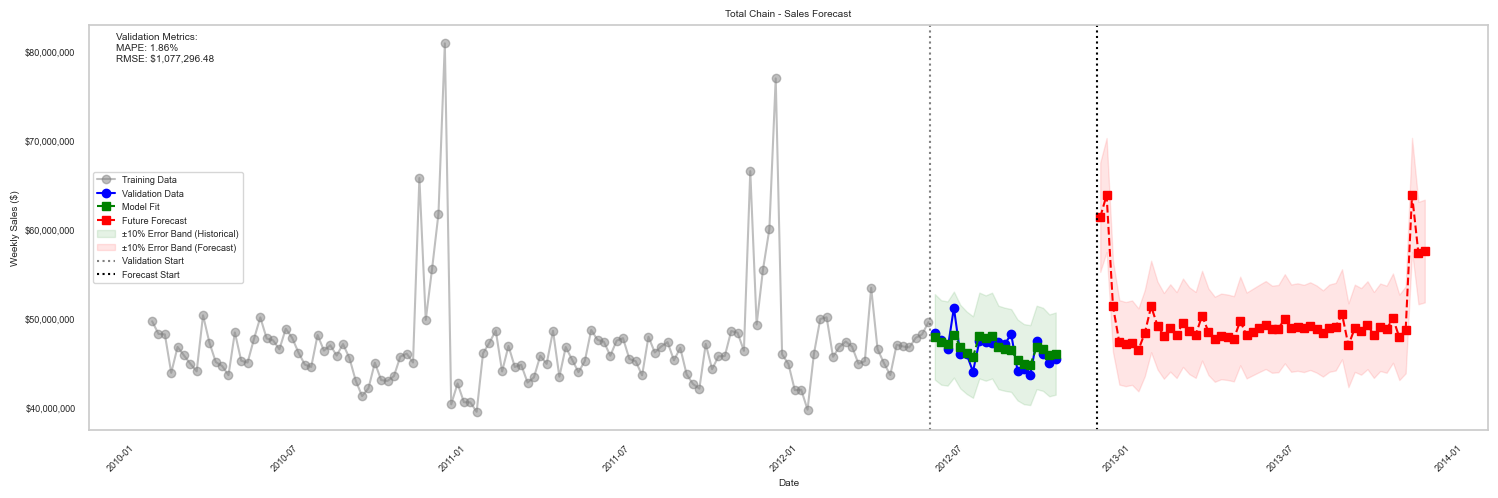

Model name: multilevel stacking
Training time: 450.77 seconds


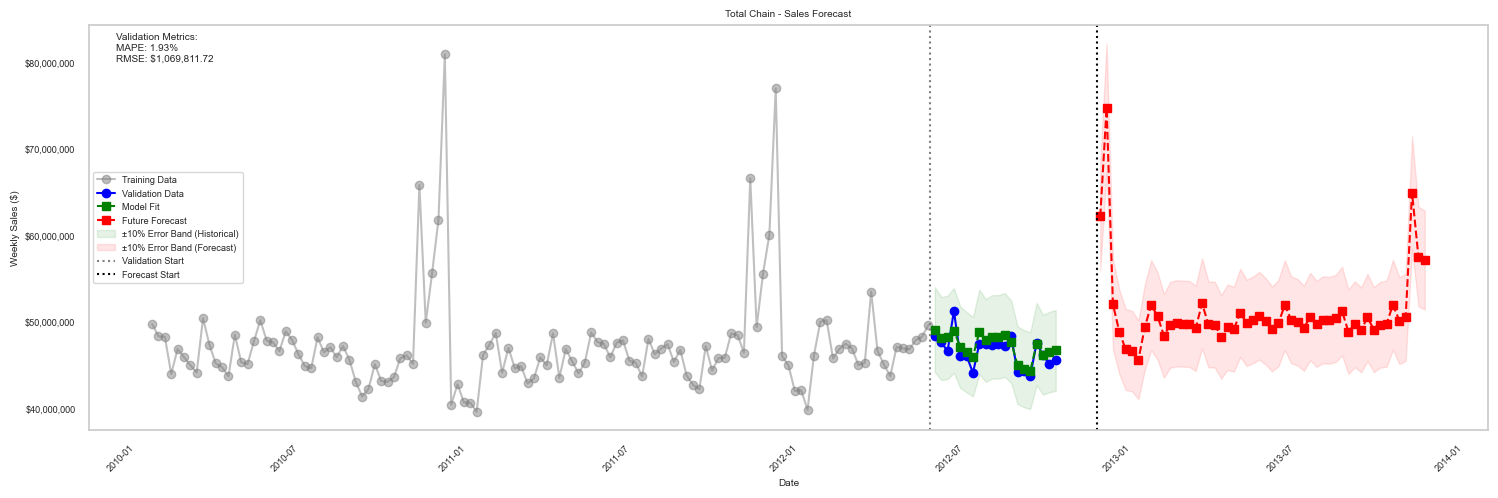

Model  MAPE_Ensemble  RMSE_Ensemble
0           weighted_blending         0.0138    978715.0000
1              ridge stacking         0.0186   1023207.0000
2  gradient_boosting stacking         0.0186   1077296.0000
3         multilevel stacking         0.0193   1069811.0000

In [76]:
df_ensemble_performance = pd.DataFrame(columns=['Model'])
for model_name in ensemble_models:
    next_idx = len(df_ensemble_performance)
    df_ensemble_performance.loc[next_idx] = [model_name]

train_and_plot_model_results(df, ensemble_models, df_ensemble_performance, trial_name='Ensemble')

In [77]:
df_ensemble_performance

Model  MAPE_Ensemble  RMSE_Ensemble
0           weighted_blending         0.0138    978715.0000
1              ridge stacking         0.0186   1023207.0000
2  gradient_boosting stacking         0.0186   1077296.0000
3         multilevel stacking         0.0193   1069811.0000

<div class="next-steps">
    <h3>Observations</h3>
    <p>Model Performance - Ensemble Models</p>
    <ol>
        <ul>At store-level, the Weighted Blending model performs the best - however, it only slightly edges out the tuned <code>GradientBoosting</code> model, which takes much less time to train.</ul>
        <ul>At chain-level, the models perform well, yet none surpass the tuned <code>XGBoost</code> and <code>GradientBoosting</code> models.</ul>
    </ol>
</div>

In essence, Ensembling did not provide a significant boost in performance that could counteract increased computational costs.

For final analysis, we will use the best performing tuned model - `GradientBoosting`.

# Summary
## Performance Overview
First, let's review MAPE and RMSE results for all the stores to see if we can spot any anomalies.

The forecast period: **2012-12-10—2013-12-10**

In [81]:
df_historical = pd.DataFrame(columns=['Store', 'Date', 'Actual'])

store_ids = df['Store'].unique()
for store_id in store_ids:
    # Get historical data
    historical_data = df[(df['Store'] == store_id) & (df['Date'] < TRAIN_END)].copy()
    historical_data = historical_data[['Store', 'Date', 'Weekly_Sales']]
    historical_data = historical_data.rename(columns={'Weekly_Sales': 'Actual'})
    df_historical = pd.concat([df_historical, historical_data])

# Get predictions
results = forecast_store_sales(
    df,
    model=best_models['gradient_boosting'],
    model_name='gradient_boosting',
)
    
# Append to main dataframes
df_metrics = pd.DataFrame.from_dict(results['store_metrics'], orient='index').reset_index(names='Store')

df_forecast = pd.concat([
    pd.DataFrame(forecast).assign(Store=store_id)
    for store_id, forecast in results['store_forecasts'].items()
])

df_validation = pd.concat([
    pd.DataFrame(validation).assign(Store=store_id)
    for store_id, validation in results['validation_predictions'].items()
])

# Format dataframes for concatenation
df_historical_exp = df_historical.copy()
df_historical_exp['Category'] = 'Historical'
df_historical_exp = df_historical_exp.rename({'Actual': 'Value'}, axis=1)
df_historical_exp = df_historical_exp[['Store', 'Date', 'Category', 'Value']]

df_forecast_exp = df_forecast.copy()
df_forecast_exp['Category'] = 'Forecast'
df_forecast_exp = df_forecast_exp.rename({'Forecast': 'Value'}, axis=1)
df_forecast_exp = df_forecast_exp[['Store', 'Date', 'Category', 'Value']]

df_validation_exp = df_validation.melt(
    id_vars=['Store', 'Date'],
    value_vars=['Actual', 'Predicted'],
    var_name='Category',
    value_name='Value'
)

df_stores_sales = pd.concat([df_historical_exp, df_forecast_exp, df_validation_exp])
df_stores_sales.to_csv(EXPORT_FOLDER + '\\stores_sales.csv', index=False)
df_metrics.to_csv(EXPORT_FOLDER + '\\stores_metrics.csv', index=False)

Additionally, let's review the metrics for each store and the forecasted sales.

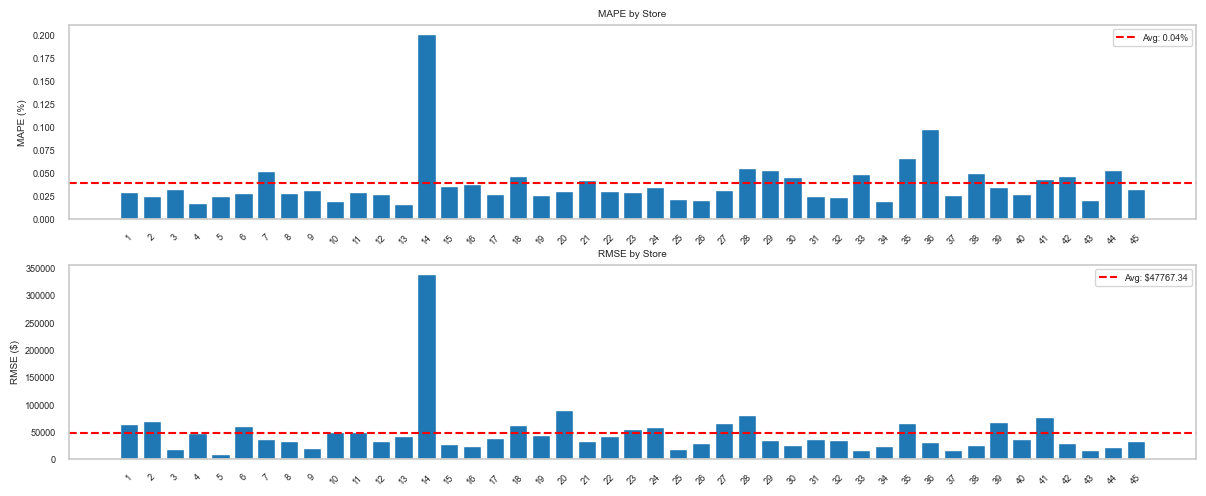

In [82]:
plot_store_metrics(df_metrics)

### Store 14 - MAPE & RMSE
Store 14 has noticeably large RMSE & MAPE, which should be reviewed.

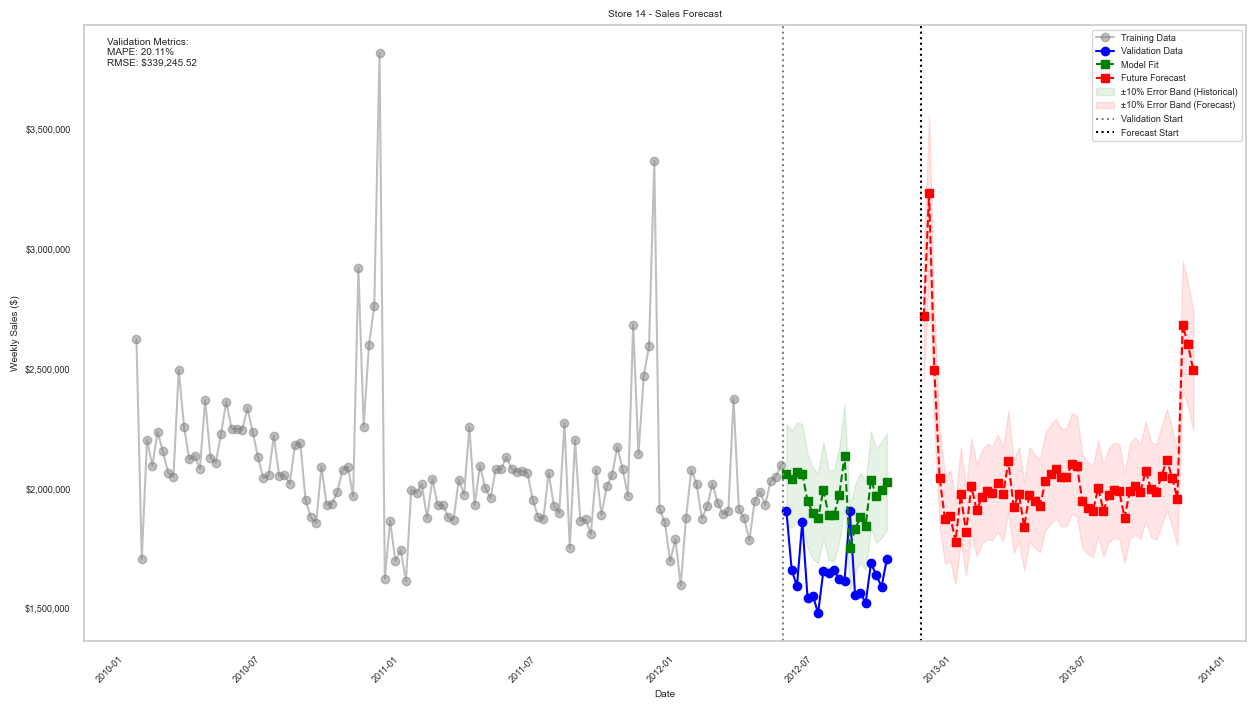

In [83]:
store_id = 14
plot_store_forecast_performance(
    store_id=store_id,
    df=df,
    validation_predictions=df_validation[df_validation['Store'] == store_id],
    store_forecasts=df_forecast[df_forecast['Store'] == store_id],
    store_metrics=df_metrics[df_metrics['Store'] == store_id],
)

It seems that the validation dataset hit a period of very poor sales. This could be the result of many factors - renovations, competitors, etc. From a long-term view, the sales are slighly decreasing, but the drop from 2012-06 onwards was not similar to past performance at all, and the timeframe of dropped sales is not long enough to properly train the model.

In essence, this drop in sales will not be captured by the model effectively at this point - a longer timeframe of the current state is needed for more accurate predictions if the lower sales are still expected.

### Store 36 - RMSE
Additionally, let's review Store `36`; The **RMSE** is pretty large, although sales (and MAPE) are small.

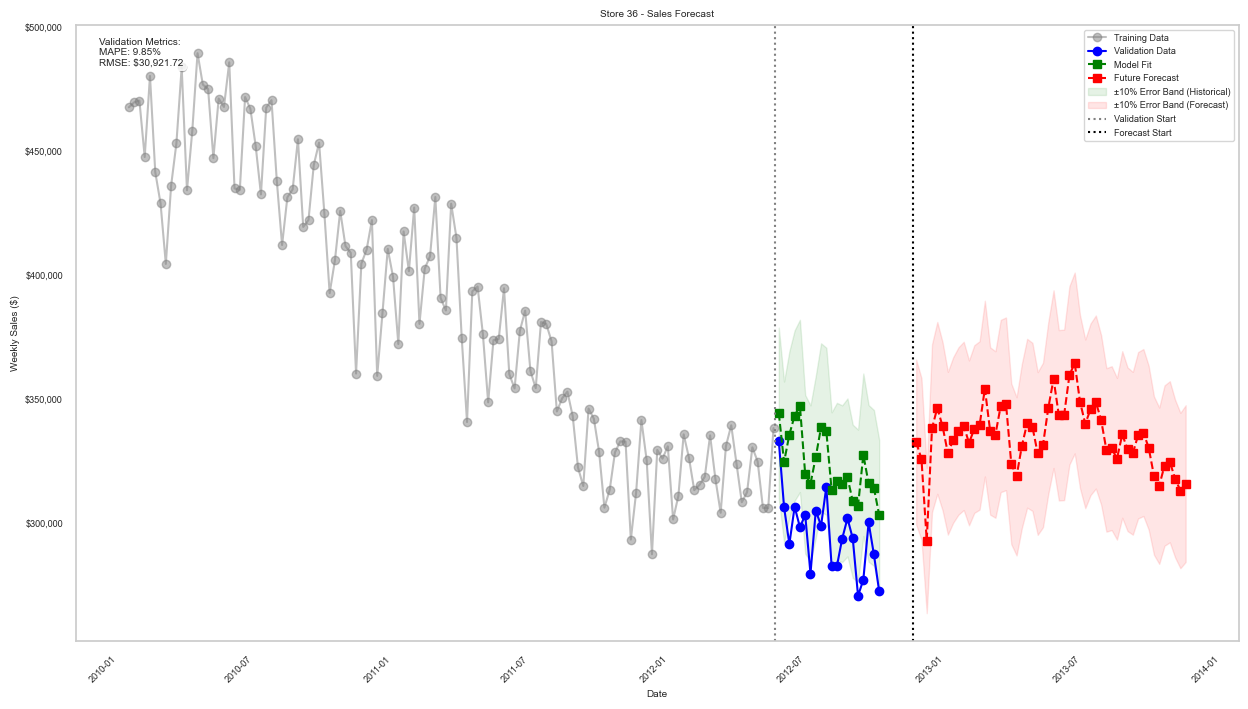

In [84]:
store_id = 36
plot_store_forecast_performance(
    store_id=store_id,
    df=df,
    validation_predictions=df_validation[df_validation['Store'] == store_id],
    store_forecasts=df_forecast[df_forecast['Store'] == store_id],
    store_metrics=df_metrics[df_metrics['Store'] == store_id],
)

In this case, it seems that the sales are continuously declining and the model predicted a slight growth of sales, most likely based on the fact that we are utilizing more than 1 year of data for training. The solution for such cases is to experiment with increased rates of weight decay for older data.

### Store 28 - RMSE & MAPE
Finally, let's review Store `28`; The **RMSE** and **MAPE** are moderately big, including an above-average forecast of sales next year.

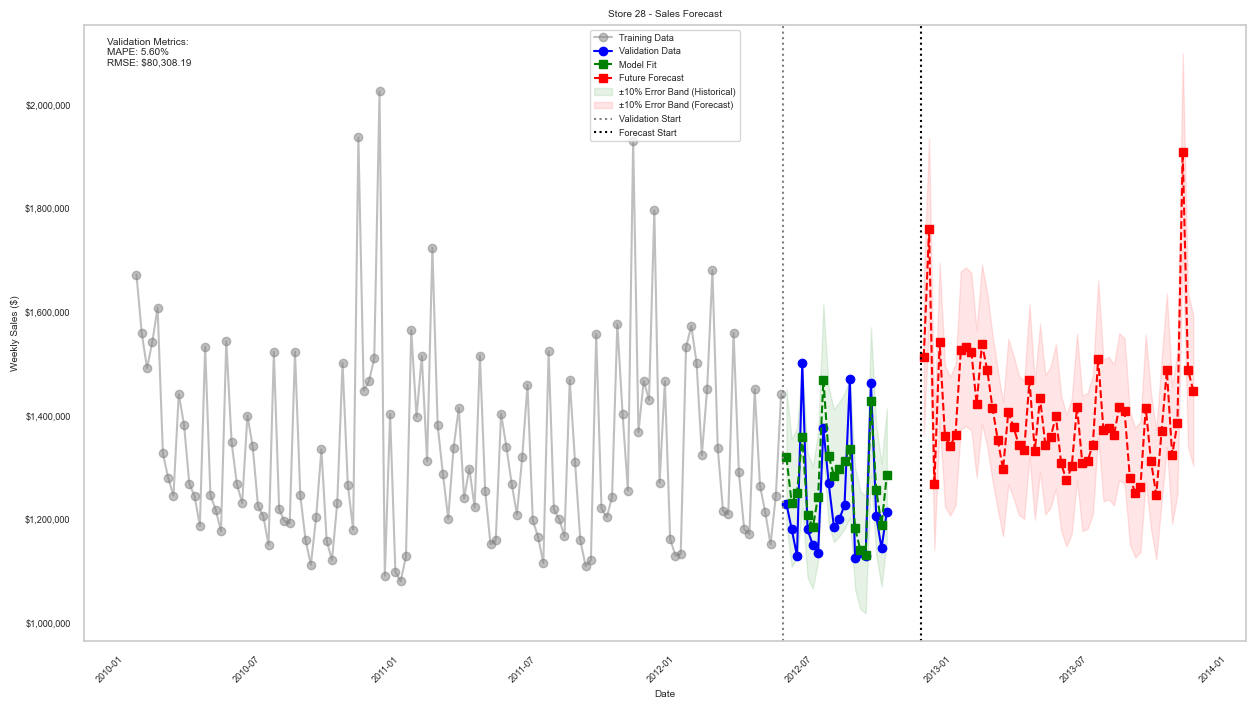

In [85]:
store_id = 28
plot_store_forecast_performance(
    store_id=store_id,
    df=df,
    validation_predictions=df_validation[df_validation['Store'] == store_id],
    store_forecasts=df_forecast[df_forecast['Store'] == store_id],
    store_metrics=df_metrics[df_metrics['Store'] == store_id],
)

It seems that the Weekly Sales in this store are very sporadic. The model predicts much less dynamic weekly sales; Both RMSE and MAPE increase as the differences between the extremes and the predictions occur. In essence, there is not much to improve in this case as well than to take a safe middle-ground. 

## Results
Using our best performing model, let's summarize the forecast:
* Weekly sales by Store
* Total retail chain sales
* Forecasted growth

Store-based weekly data by week can be accessed through an interactive visual in Tableau. **LINK**

### Total Sales by Store

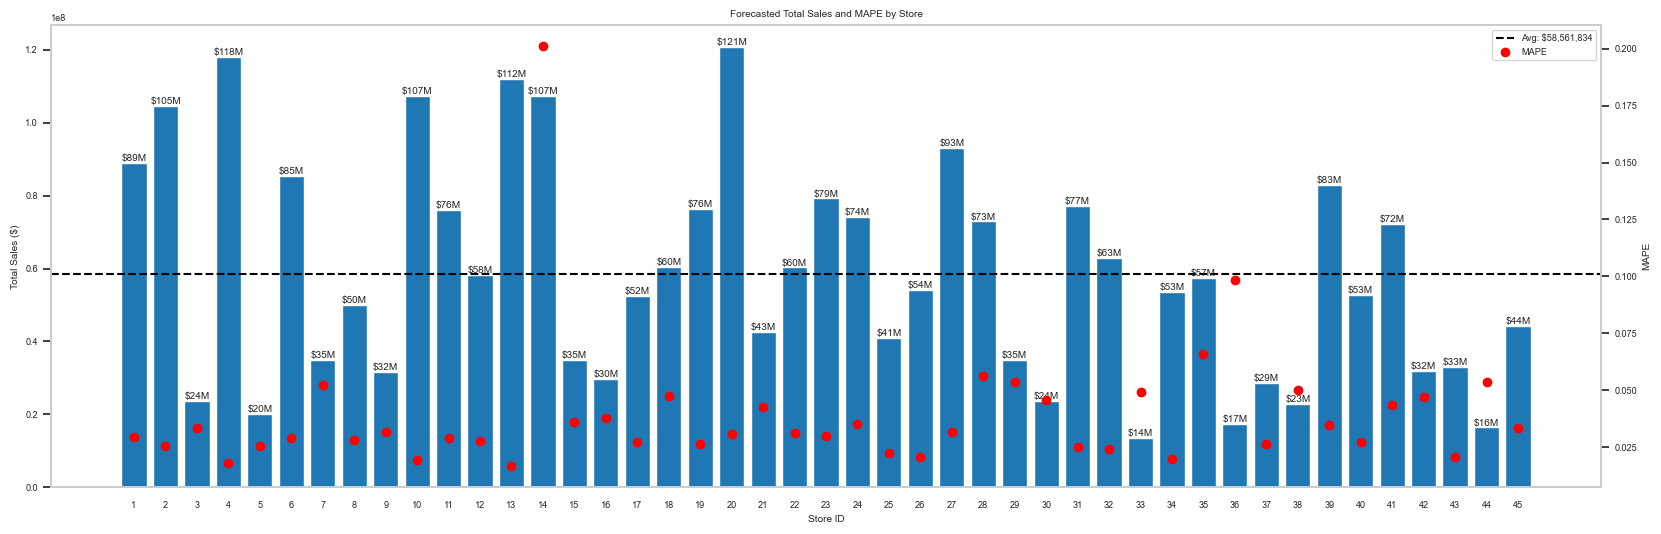

In [86]:
store_sales = df_forecast.groupby('Store')['Forecast'].sum().reset_index()
store_sales = store_sales.sort_values('Store')
plot_forecasted_sales(store_sales, df_metrics)

<div class="next-steps">
    <h3>Observations</h3>
    <p>Forecasted Total Sales by Store</p>
    <ol>
        <ul>Sales by Stores take up two extremes, although the upper-end is pretty similar among each other with about ~110M in Sales</ul>
        <ul>Most Stores have a MAPE of less than 0.06, which means that for most stores we should expect the forecasts to be off by less than 0.6% on average</ul>
        <ul>As noted previously, Stores 14, 28 and 36 have higher uncertainty due to their unique case of sales trends</ul>
    </ol>
</div>

### Total Retail Chain Sales

In [87]:
print(f'Total Sales ({FORECAST_START}—{FORECAST_END}): ${(store_sales['Forecast'].sum()/1e6):.2f}M')

Total Sales (2012-12-10—2013-12-10): $2635.28M


Our sales forecast model predicts $2.635B in sales from December 2012 to December 2013. Based on validation testing, we expect our forecasts to be off by less than 1.5% on average, with typical errors around $878K - which is quite small relative to our total sales volume.

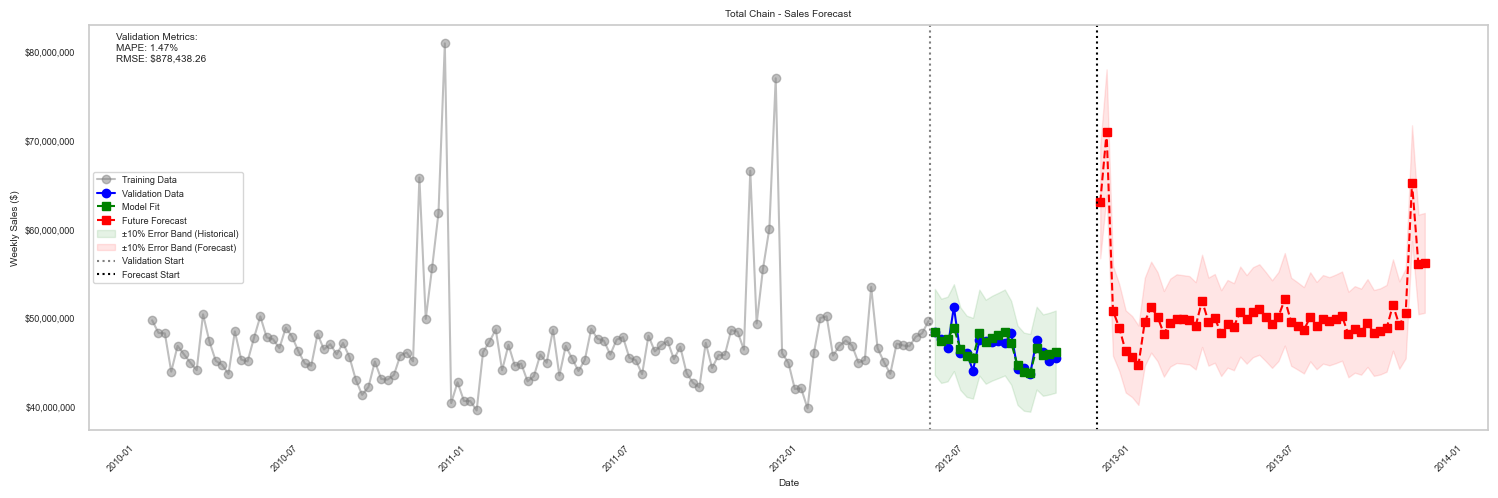

In [88]:
results = forecast_store_sales(
    df,
    model=best_models['gradient_boosting'],
    model_name='gradient_boosting',
)

plot_chain_forecast_performance(
    df,
    validation_predictions=results['chain_val_data'],
    chain_forecast=results['chain_forecast_data'],
    chain_metrics=results['chain_metrics']
)

### Forecasted growth by Stores
Let's review the change in total sales for the same period last year.

Forecast Period: 2012-12-10 — 2013-10-26
Benchmark Period: 2011-12-10 — 2012-10-26


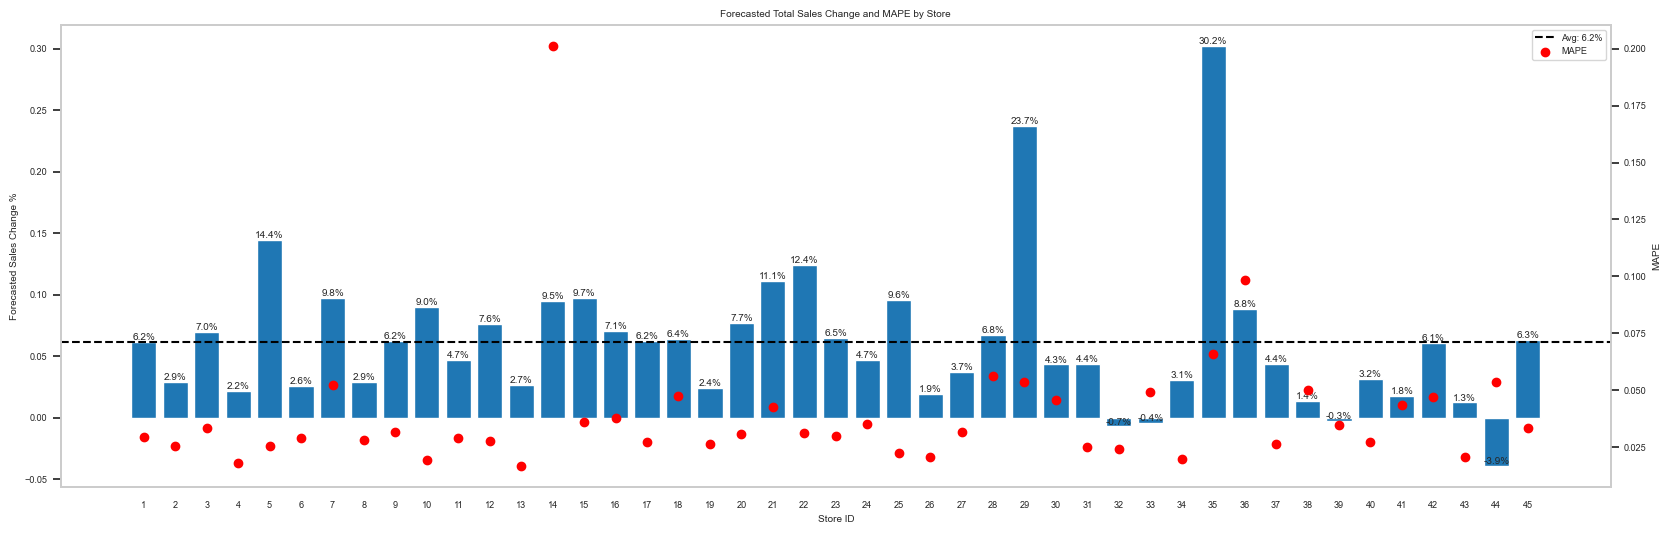

In [89]:
print(f'Forecast Period: {FORECAST_START} — 2013-10-26')
sales_py_start = datetime.strptime(FORECAST_START, "%Y-%m-%d")
sales_py_start = sales_py_start.replace(year=sales_py_start.year - 1).strftime("%Y-%m-%d")
print(f'Benchmark Period: {sales_py_start} — 2012-10-26')

# Calculate sales of benchmark period by week
df_sales_benchmark = df[(df['Date'] >= sales_py_start)&(df['Date'] < FORECAST_START)]
df_sales_benchmark = df_sales_benchmark.groupby('Store')['Weekly_Sales'].sum().reset_index()

# Calculate sales of forecast period by week
df_sales_forecast = df_forecast[df_forecast['Date'] <= '2013-10-26']
df_sales_forecast = df_sales_forecast.groupby('Store')['Forecast'].sum().reset_index()

# Merge both dataframes, calculate change
df_growth = pd.merge(df_sales_benchmark, df_sales_forecast, how='left', on='Store')
df_growth['Change'] = (df_growth['Forecast'] - df_growth['Weekly_Sales']) / df_growth['Weekly_Sales']
df_growth.head()
df_growth = df_growth[['Store', 'Weekly_Sales', 'Forecast', 'Change']]

# Plot changes
plot_forecasted_sales_change(df_growth, df_metrics)

#### Store 29 & 35 - Exceptional Growth

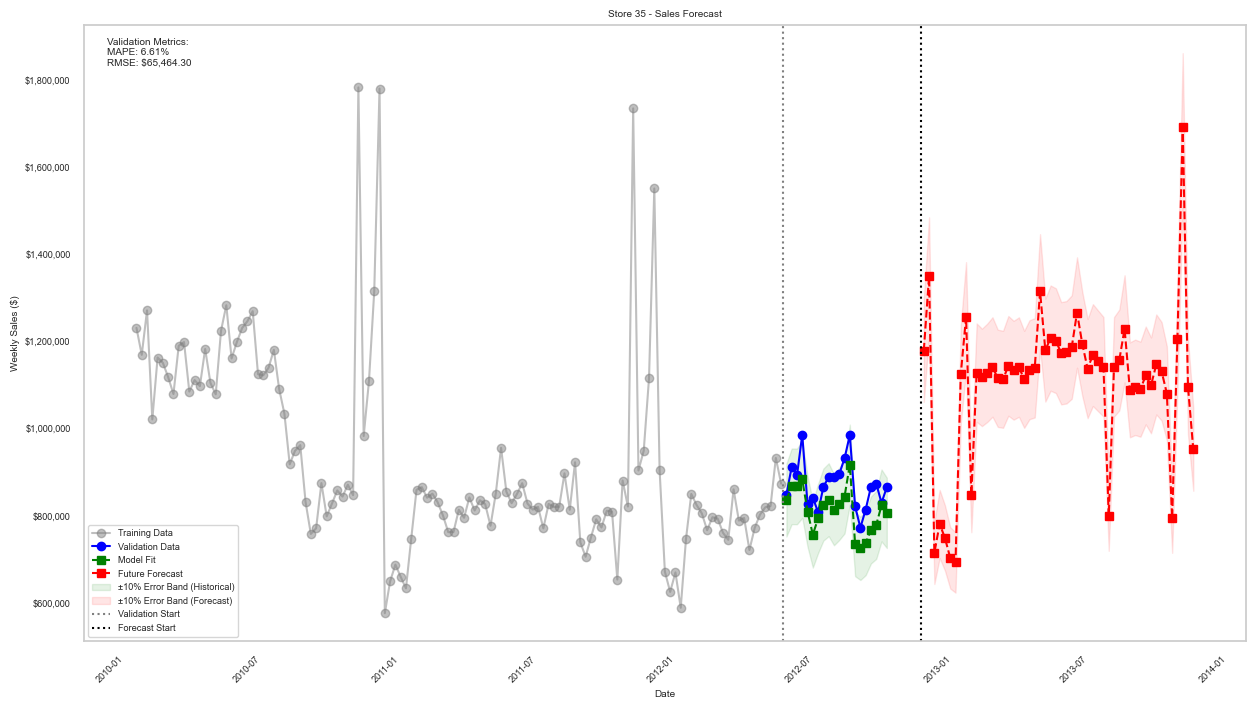

In [90]:
store_id = 35
plot_store_forecast_performance(
    store_id=store_id,
    df=df,
    validation_predictions=df_validation[df_validation['Store'] == store_id],
    store_forecasts=df_forecast[df_forecast['Store'] == store_id],
    store_metrics=df_metrics[df_metrics['Store'] == store_id],
)

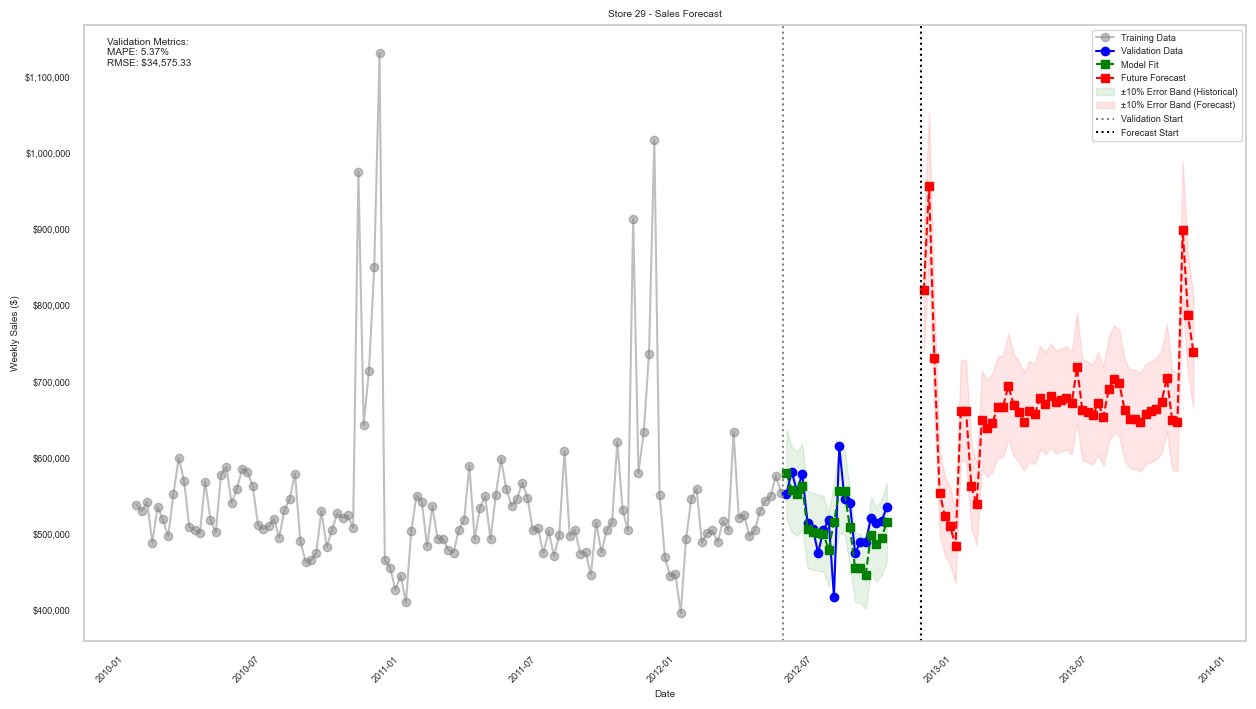

In [91]:
store_id = 29
plot_store_forecast_performance(
    store_id=store_id,
    df=df,
    validation_predictions=df_validation[df_validation['Store'] == store_id],
    store_forecasts=df_forecast[df_forecast['Store'] == store_id],
    store_metrics=df_metrics[df_metrics['Store'] == store_id],
)

In both cases, it seems that unstable sales and sharp jumps in sales result in very optimistic sales predictions for the model. What's strange is that the validation period for the stores is not very distant from actual sales, although the metrics are worse than average. The solution here is to perform additional feature engineering by integrating more data about the stores.

## Conclusion
During the study, we have performed the following:
* Analyzed seasonal & holiday trends in the dataset - spikes in weekly sales often occur during holiday weeks or after them (e.g., first weeks of January)
* Created new features:
  * Time-based cyclical features
  * Seasonal & history multipliers to better inherit sales patterns in forecasting
* Reviewed feature importances through Mutual Information, built-in XGBoost and LightGBM feature importance values and PhiK correlation matrix. Departments, Store numbers, Sizes and newly created seasonality & holiday patterns prove to be exceptionally useful for the model to approximate sales
* Performed Statistical Modeling based on these parameters:
  * **Data Split**:
    * Train - 2010-02-05 to 2012-06-10 (28 months)
    * Validation - 2012-06-10 to 2012-12-10 (6 months)
    * Forecast - 2012-12-10 to 2023-12-10 (1 year)
  * **Data weighing** - dynamic weighing based on data age; Data older than 2012 loses 0.3 of weight for each subsequent year.
  * **Performance Metric**: RMSE and MAPE
  * **Models**:
      * XGBoost
      * GradientBoosting
      * LightGBM
      * CatBoost
      * ElasticNet
  * **Baseline**: Result of the best performing model on the raw data
* The Statistical Modeling was performed on the following iterations:
  * Baseline (raw data)
  * Feature Engineering
  * Model Tuning with Optuna
  
Each iteration produced better results for both performance metrics. The best model was `GradientBoosting` with a MAPE of 0.0147 and RMSE of $878,438.

* The tuned models were used in model ensembling, creating the following models:
  * Weighted Prediction Blending
  * Stacking Regressor - Ridge meta-learner
  * Stacking Regressor - GradientBoosting meta-learner
  * Multi-Level Stacking Regressor - Two levels, Lasso meta-learner
Unfortunately, the ensemble models did not produce a good enough result to justify increased computational costs.
* Analyzed performance metrics for each store
  * In general, most stores have a MAPE score of less than 0.004
  * Stores 14, 28, 29, 35 and 36 have unstable / continuously decreasing sales. The model struggled with properly forecasting the sales for these stores.
* Sales by Store have been published to Tableau Public - [Link](https://public.tableau.com/app/profile/pijus.jur.iukonis/viz/stores_sales/Dashboard1)
* From the Retail Chain perspective with sales of about $2.6B, the results are acceptable; The model predicts a prediction error of 1.47%, which is approximately $878k;

## Improvements for Future Studies
### Functionality
1. Use the model after each quarter / half-year with a shorter forecast length. Implement moving historical data window (e.g., last two years) to avoid underfitting, especially for stores that are experiencing continuous growth/decline.
2. Tune different models for each store category, as their sales growth differs significantly. Categories may include stable sales / declining sales / new stores (fast growth).

### Analysis
1. Department-related data seemed to be very important for the model to forecast weekly sales. For a more detailed strategy, review forecasted sales by departments / train models on department-level data to strategize on which departments more focus should be allocated.
2. External features such as Temperature, CPI or Unemployment were not suitable enough for forecasting, since neither store has location-based data for which we can try and look up these variables forecasts. Consider getting location-based data for an even better model performance.
3. Add more features to the dataset for better sales prediction. Features that could better help identify root causes for jumps in sales and could be imputed in forecasting would significantly improve model performance, especially with stores that have inconsistent revenues.

### Models
1. Consider trying specialized forecasting models like Meta's Prophet, Amazon's Chronos T5 or SARIMAX, which were designed to forecast on seasonal data.
2. Expand the hyperparameter tuning to try and get slightly better performance, since the models are tuned relatively quick.